<a href="https://colab.research.google.com/github/venkataprasannakumar1/cars_auctioned/blob/main/TrafficTelligence_Advanced_Traffic_Volume_Estimation_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_regression, SelectPercentile, SelectKBest, RFE

### Pre-processing

In [8]:
# Reading the Training Data
df = pd.read_csv("/content/traffic volume.csv")

In [9]:
# 1. Displaying the first 10 records
# 1. Displaying the first 10 records
# 2. Check dataset info - field types, non-null values, dtypes
# df.shape
# df.columns
# df.dtypes
# df.describe()
df.info()
# df.nunique()
# df['weather_description'].unique()
# df.tail(5)
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48151 non-null  float64
 2   rain            48202 non-null  float64
 3   snow            48192 non-null  float64
 4   weather         48155 non-null  object 
 5   date            48204 non-null  object 
 6   Time            48204 non-null  object 
 7   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 2.9+ MB


holiday           48143
temp                 53
rain                  2
snow                 12
weather              49
date                  0
Time                  0
traffic_volume        0
dtype: int64

In [10]:
df['date_time'] = pd.to_datetime(df['date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')
df['date_month_no']= df['date_time'].dt.month
df['date_day']= df['date_time'].dt.day
df['date_hour']= df['date_time'].dt.hour
df['weekday'] = df['date_time'].dt.weekday
df['is_weekend'] = df['date_time'].dt.dayofweek // 5
df['hour_sin'] = np.sin(2 * np.pi * df['date_hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['date_hour'] / 24)
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
df['date_day_sin'] = np.sin(2 * np.pi * df['date_day'] / 31)
df['date_day_cos'] = np.cos(2 * np.pi * df['date_day'] / 31)
df['day_of_year'] = df['date_time'].dt.dayofyear
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

In [11]:
# 2. Check dataset info - field types, non-null values, dtypes

In [12]:
# 3a. Pre-processing (Cleaning): Address missing (NULL) values - drop or imputation
values = {
    'temp': df['temp'].mean(),
    'rain': df['rain'].interpolate(method='linear'),
    'snow': df['snow'].interpolate(method='linear')
}
df.fillna(value=values, inplace=True)
df.dropna(subset= ['traffic_volume','weather','date_time'], inplace=True)

In [13]:
# 3c. Pre-processing (Cleaning): Drop irrelevant columns (that you don't want to give as input to the model)
df = df.drop(columns=["holiday","date_time"])

In [14]:
# 3d. Pre-processing (Encoding): Convert categorical values to numeric
# Use df['col_name'].value_counts() to find out all the categories available per column

# df['col_name'].value_counts()
df = df.drop(columns=["date","Time"])
df = pd.get_dummies(df, columns=['weather'])

In [15]:
# in order to match hotcoding with test data i am manually deleting those unavailable in test data
# df= df.drop(columns=["weather_description_light rain and snow","weather_description_shower snow","weather_description_thunderstorm with drizzle","weather_description_sleet"])

In [16]:
# 3b. Pre-processing (Cleaning): Remove Duplicate Rows
df.drop_duplicates(inplace=True)

In [17]:
# 4a. Data understanding - Find out stats regarding your data (df.describe(), df.mean(), df.median())
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 47924 entries, 0 to 48203
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp                  47924 non-null  float64
 1   rain                  47924 non-null  float64
 2   snow                  47924 non-null  float64
 3   traffic_volume        47924 non-null  int64  
 4   date_month_no         47924 non-null  int32  
 5   date_day              47924 non-null  int32  
 6   date_hour             47924 non-null  int32  
 7   weekday               47924 non-null  int32  
 8   is_weekend            47924 non-null  int32  
 9   hour_sin              47924 non-null  float64
 10  hour_cos              47924 non-null  float64
 11  weekday_sin           47924 non-null  float64
 12  weekday_cos           47924 non-null  float64
 13  date_day_sin          47924 non-null  float64
 14  date_day_cos          47924 non-null  float64
 15  day_of_year           47

temp                    0
rain                    0
snow                    0
traffic_volume          0
date_month_no           0
date_day                0
date_hour               0
weekday                 0
is_weekend              0
hour_sin                0
hour_cos                0
weekday_sin             0
weekday_cos             0
date_day_sin            0
date_day_cos            0
day_of_year             0
day_of_year_sin         0
day_of_year_cos         0
weather_Clear           0
weather_Clouds          0
weather_Drizzle         0
weather_Fog             0
weather_Haze            0
weather_Mist            0
weather_Rain            0
weather_Smoke           0
weather_Snow            0
weather_Squall          0
weather_Thunderstorm    0
dtype: int64

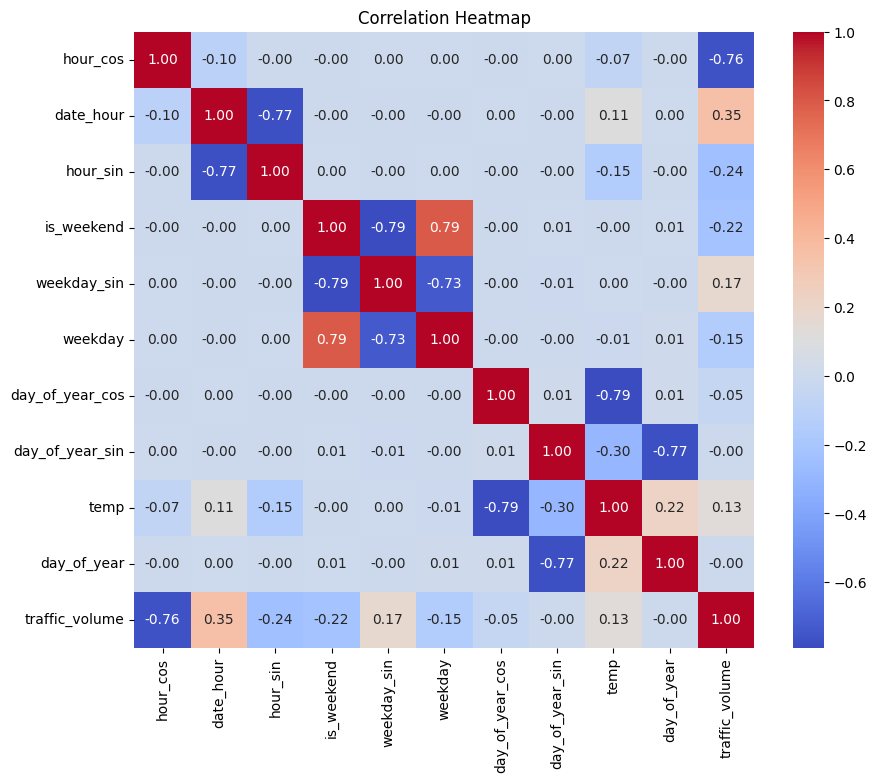

In [38]:
# 4b. Data understanding - Make use of plots to build more understanding of the data
# Hint: Can use df.plot()
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr = df[features + ['traffic_volume']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

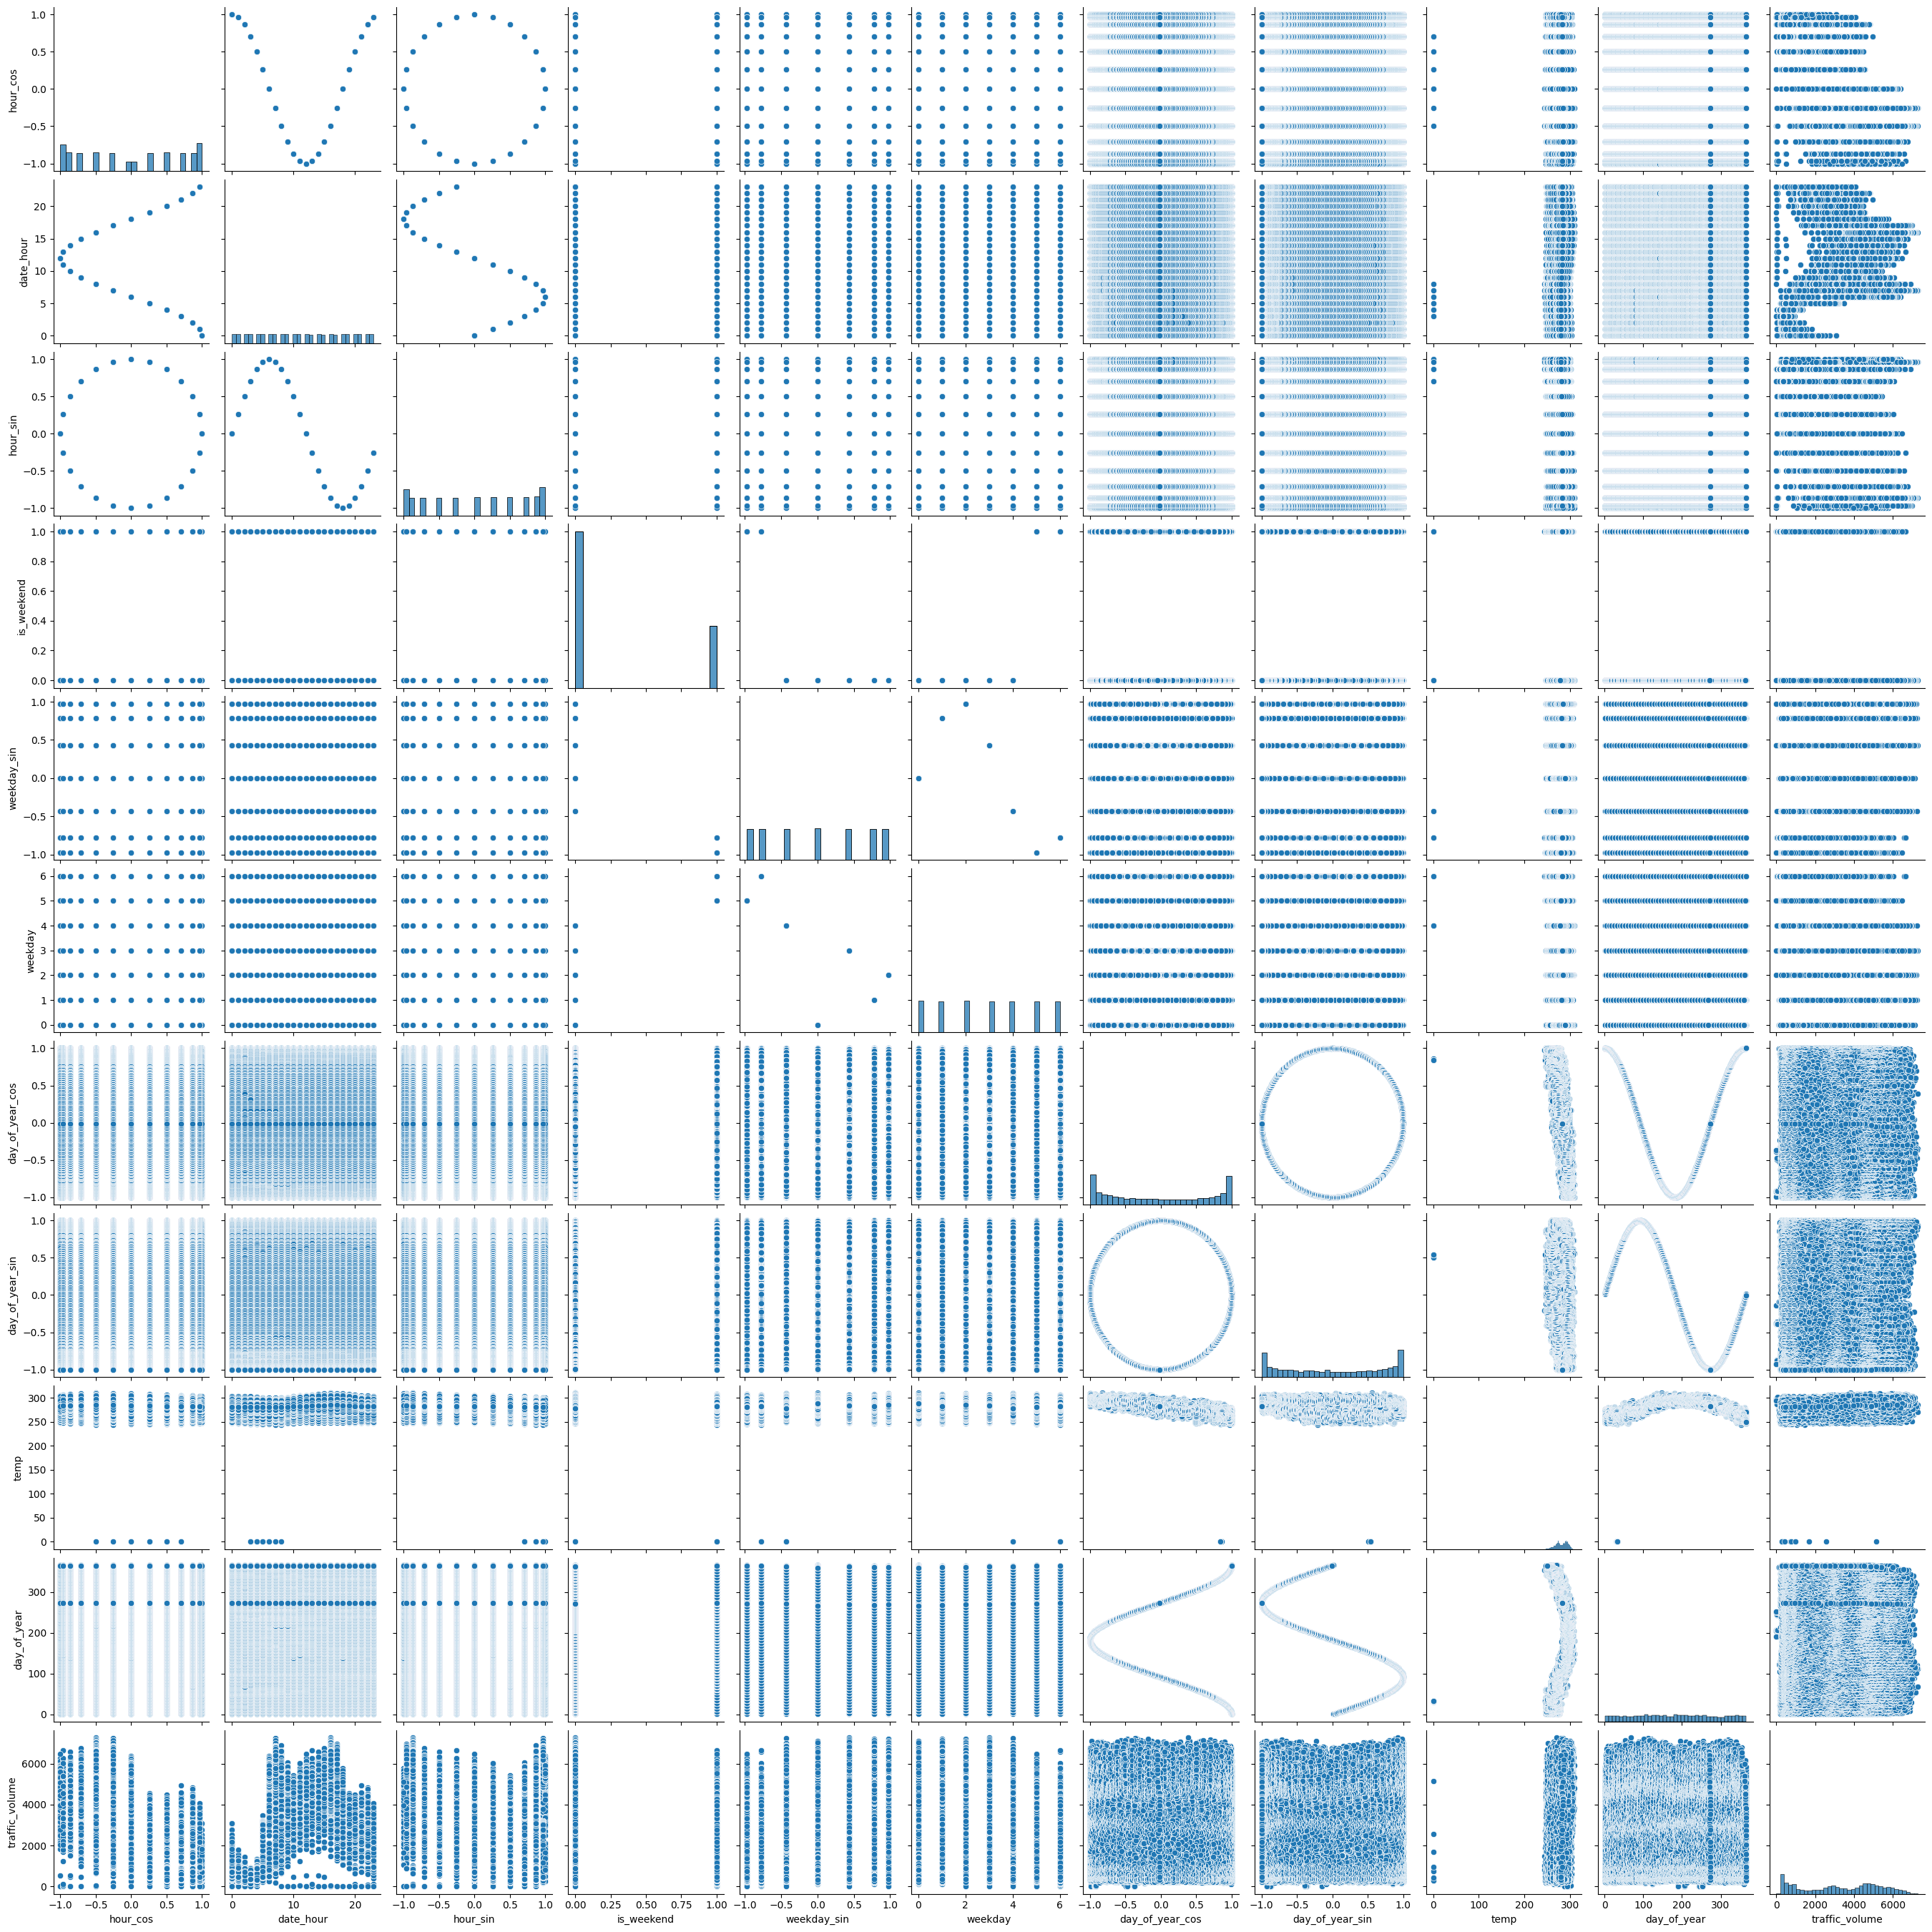

In [49]:
import seaborn as sns
sns.pairplot(df [features + ['traffic_volume']])
plt.show()

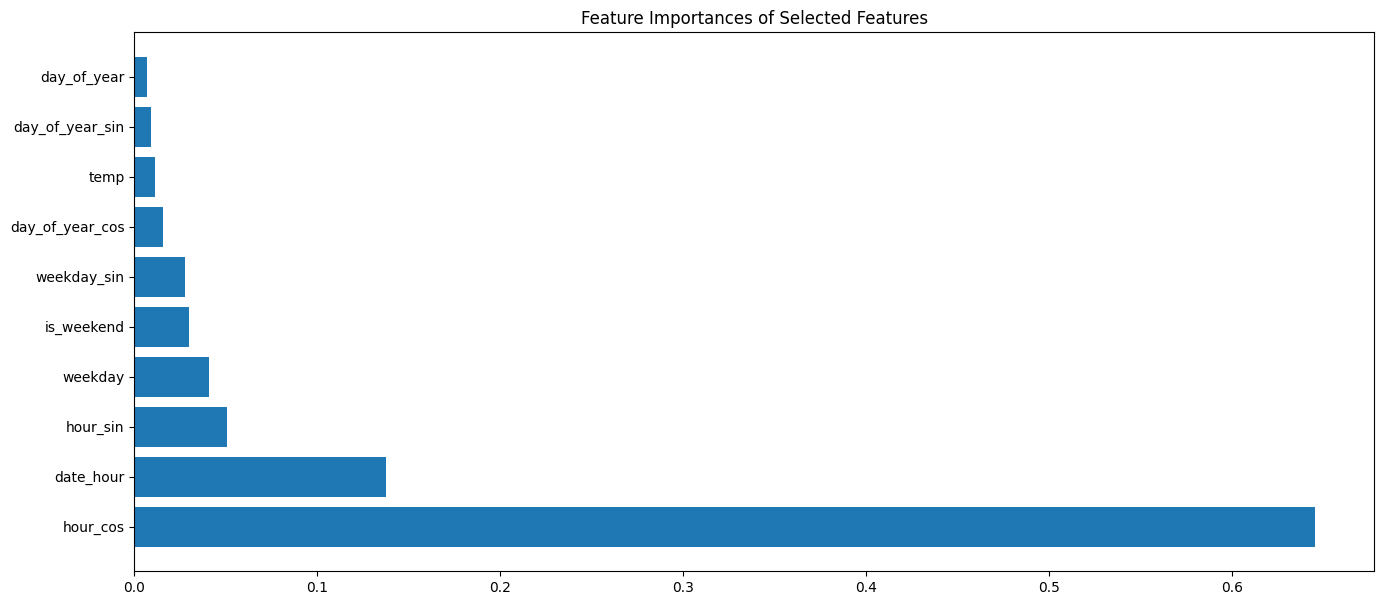

In [52]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming you have already trained a RandomForestRegressor model named 'selector'
# and calculated feature_importances and selected_features_names

# feature_importances = selector.feature_importances_
# selected_features_indices = (-feature_importances).argsort()[:10] # Assuming top 10 are selected
# selected_features_names = x.columns[selected_features_indices] # Assuming x is your original feature dataframe

plt.figure(figsize=(16, 7))
# Use selected_features_indices to get the importance values for the selected features
plt.barh(range(len(selected_features_names)), feature_importances[selected_features_indices], align='center')
plt.yticks(range(len(selected_features_names)), selected_features_names) # Use selected_features_names for labels
plt.title('Feature Importances of Selected Features')
plt.show()

In [53]:
# 4b. (Optional) Create More plots to understand the relationship b/w different variables

# Example: Top 20 actors of movies based on the imdb rating of the movies

# plt.figure(figsize=(10, 8))

# # Create a new dataframe with top 20 values
# new_df = df.sort_values(by ='imdb_score' , ascending=False)
# new_df = new_df.head(20)

# # plotting
# ax=sns.pointplot(x=new_df['actor_1_name'], y=new_df['imdb_score'], hue=new_df['movie_title'])
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# plt.tight_layout()
# plt.show()

In [54]:
# 4c. Find out which input features are the most important
# Hint: Start out with df.corr(). Can visualise with seaborn library

In [55]:
# Any other relevant pre-processing (upto your exploration)

### Model Development

In [57]:
# 1. Divide dataframe into input and output
# X = df.drop(columns=['output_class']) -> Drop the column to be predicted
# y = df['output_class'] -> Choose Output column to be predicted
x = df[[ 'temp', 'rain', 'snow', 'date_month_no',
       'date_day','date_hour','weekday','is_weekend','hour_sin','hour_cos','weekday_sin','weekday_cos',
       'date_day_sin','date_day_cos','day_of_year','day_of_year_sin','day_of_year_cos', 'weather_Clear',
       'weather_Clouds', 'weather_Drizzle', 'weather_Fog',
       'weather_Haze', 'weather_Mist', 'weather_Rain',
       'weather_Smoke', 'weather_Snow', 'weather_Squall',
       'weather_Thunderstorm']]
y = df['traffic_volume']
feature_names = x.columns

In [58]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Feature Selection with Random Forest
selector = RandomForestRegressor(n_estimators=100, random_state=42)
selector.fit(x, y)

# Get feature importances
feature_importances = selector.feature_importances_

# Get indices of the top 6 features
selected_features_indices = (-feature_importances).argsort()[:10]

# Create a new DataFrame with only the selected features
x_new = x.iloc[:, selected_features_indices]

# Get the names of the selected features
selected_features_names = x.columns[selected_features_indices]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2)

# Train the XGBoost Regressor model
model = XGBRegressor()
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Evaluate the model
print('R^2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))


R^2 Score: 0.9767701029777527
Mean Squared Error: 91825.3046875


In [59]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Assuming x_train, y_train are your training data and labels

# Hyperparameter tuning
parameters = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb = XGBRegressor()
clf = GridSearchCV(xgb, parameters, scoring='neg_mean_squared_error')
clf.fit(x_train, y_train)

# Use the best parameters for the model
model = clf.best_estimator_

# Optionally, re-evaluate feature importance and select top features
# model.fit(x_train[selected_features], y_train)
# predictions = model.predict(x_test[selected_features])

# Evaluate the model

In [60]:
# Assuming 'model' is your updated model after hyperparameter tuning or feature selection
model.fit(x_train, y_train)  # Retrain the model with the training data

y_pred = model.predict(x_test)  # Make predictions on the test data

# Calculate the Mean Squared Error to evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 73251.234375


In [61]:
selected_features_names



Index(['hour_cos', 'date_hour', 'hour_sin', 'weekday', 'is_weekend',
       'weekday_sin', 'day_of_year_cos', 'temp', 'day_of_year_sin',
       'day_of_year'],
      dtype='object')

In [62]:
# 3. Data Normalisation: Bring into the range 0 to 1, or -1 to 1

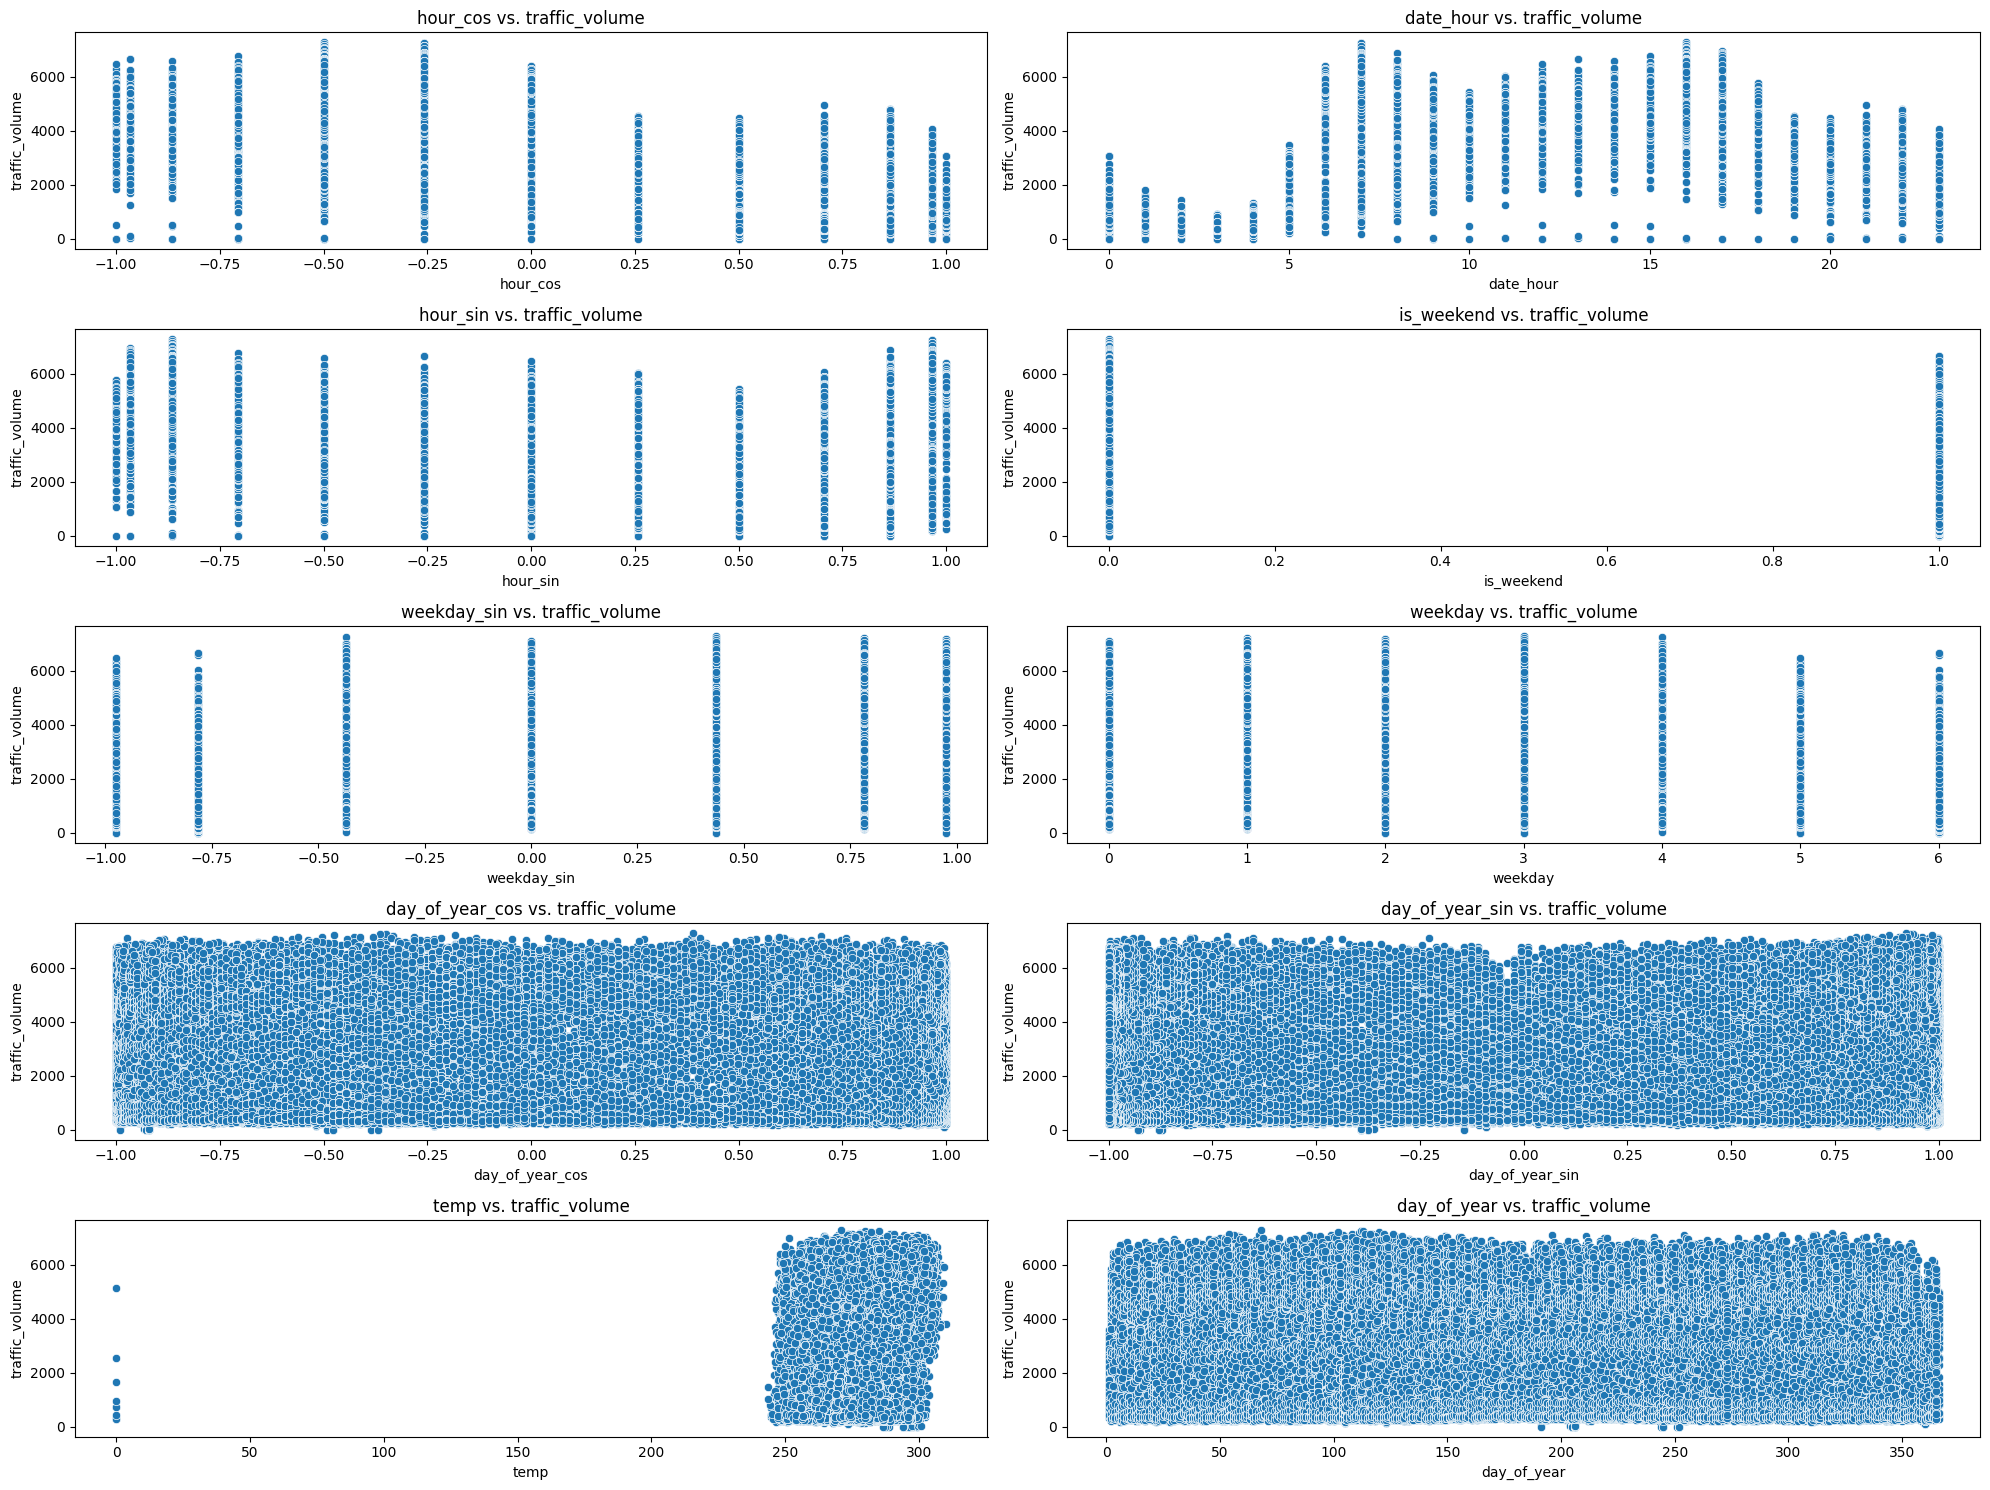

In [63]:
# 4. Choose Model(s), fit
### Experiment with different models.
### https://scikit-learn.org/stable/supervised_learning.html
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it contains both the features and the target variable
features = ['hour_cos', 'date_hour', 'hour_sin', 'is_weekend', 'weekday_sin',
            'weekday', 'day_of_year_cos', 'day_of_year_sin', 'temp', 'day_of_year']
target = 'traffic_volume'

# Set the size of the plots
plt.figure(figsize=(20, 15))

for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)  # Adjust the grid size according to the number of features
    sns.scatterplot(x=df[feature], y=df[target])
    plt.title(f'{feature} vs. {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

In [64]:
pip install matplotlib seaborn

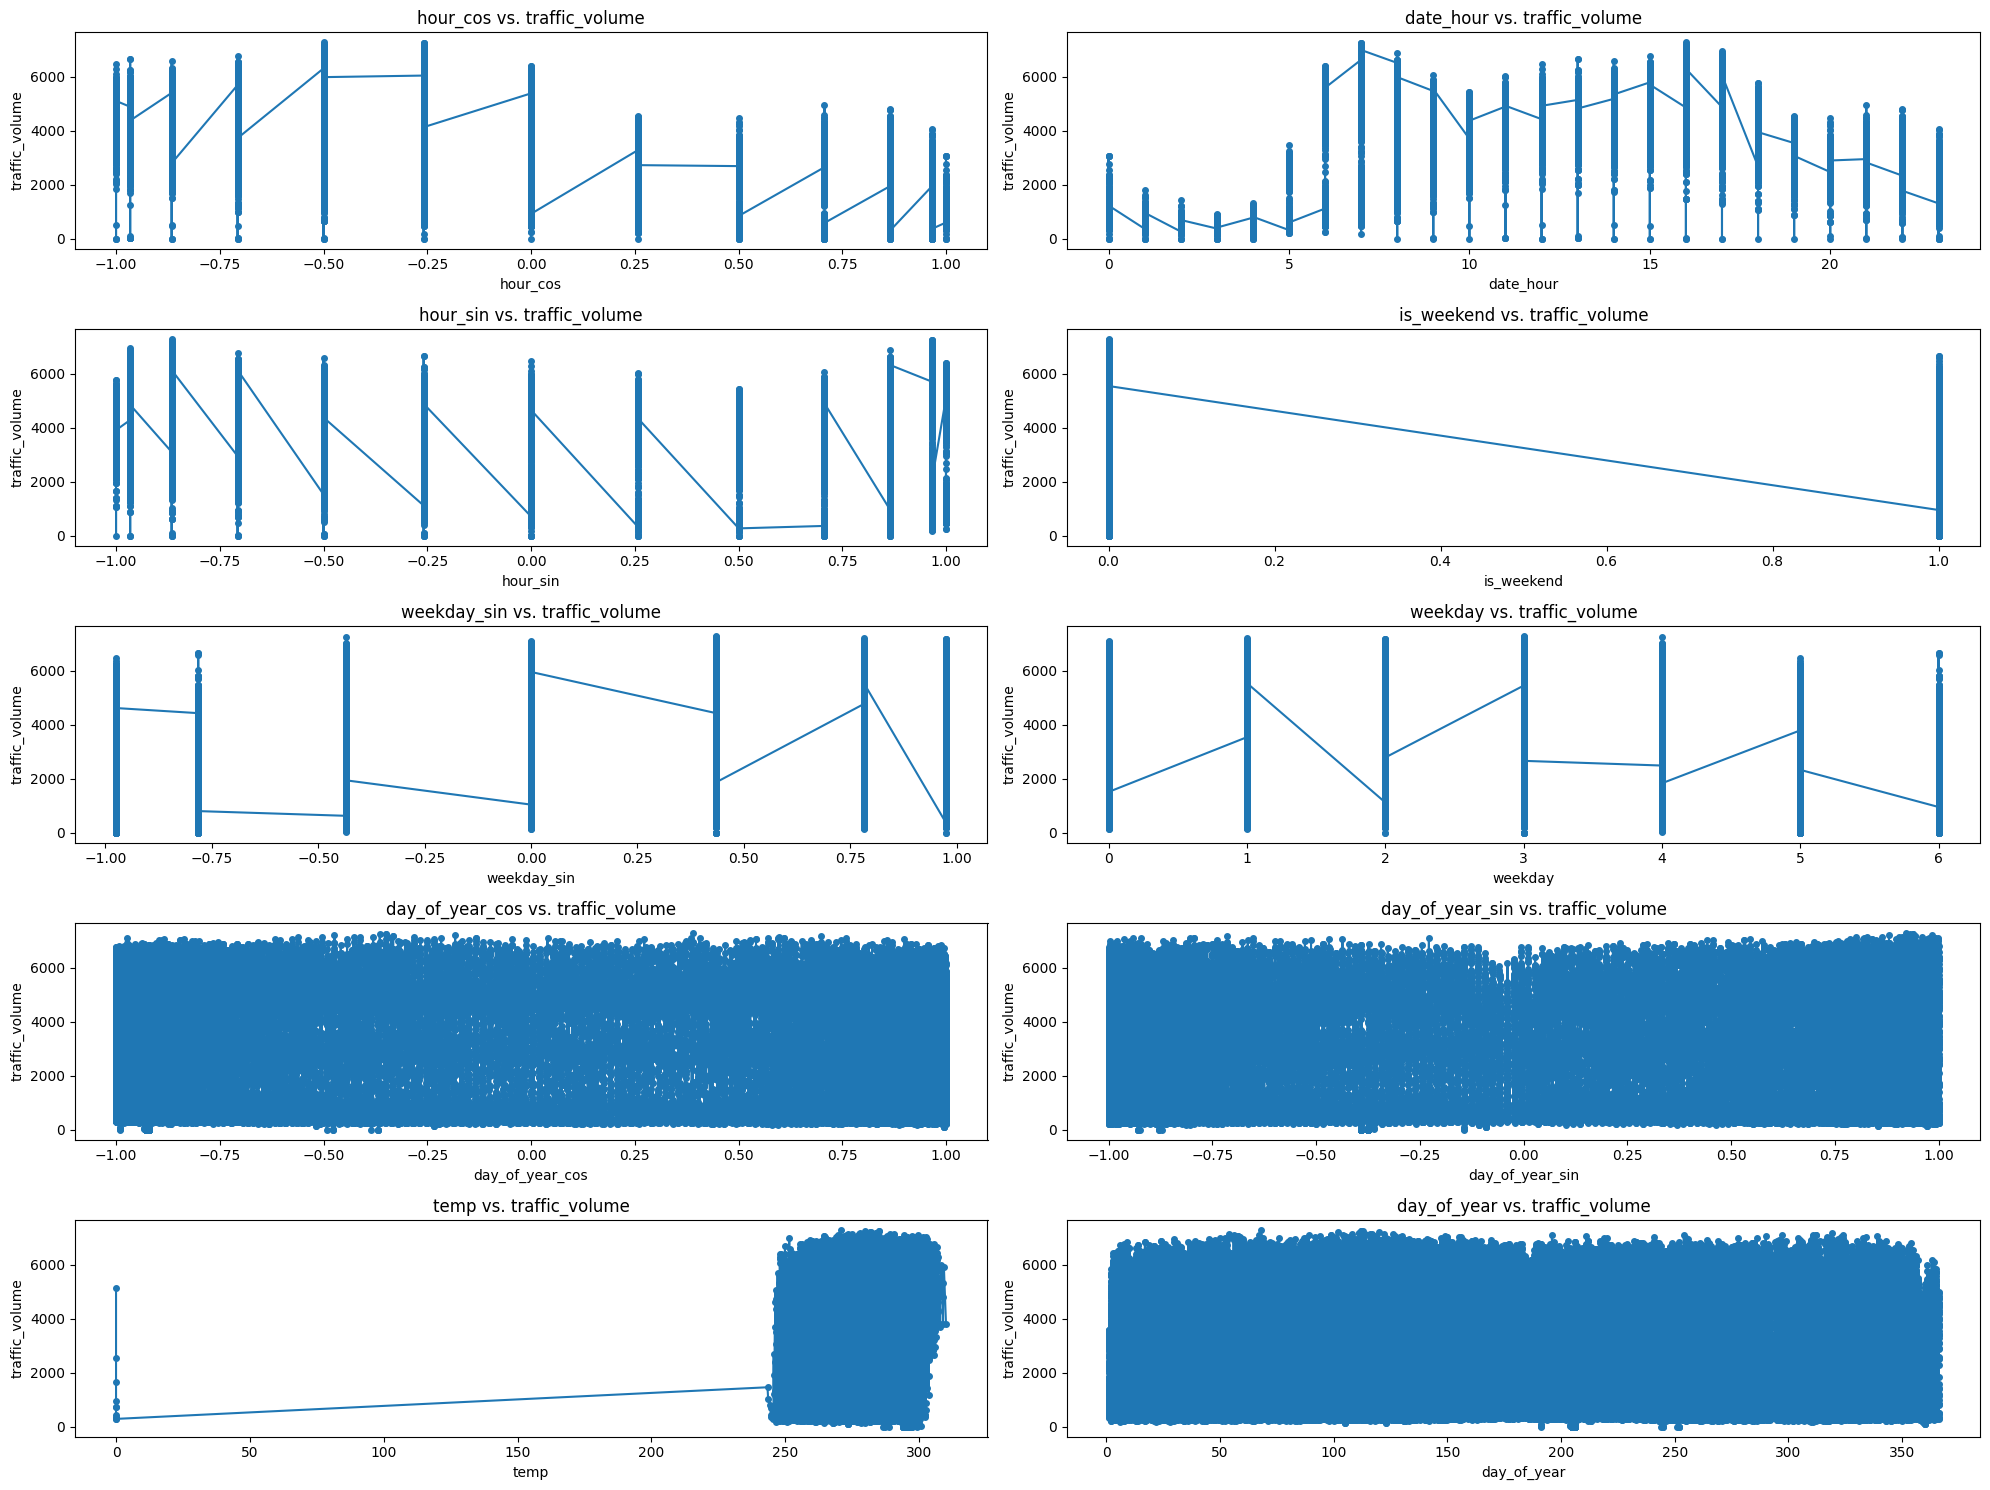

In [65]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)
    # Sorting values for better line plot visualization
    sorted_df = df.sort_values(by=feature)
    plt.plot(sorted_df[feature], sorted_df[target], marker='o', linestyle='-', markersize=4)
    plt.title(f'{feature} vs. {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
plt.tight_layout()
plt.show()

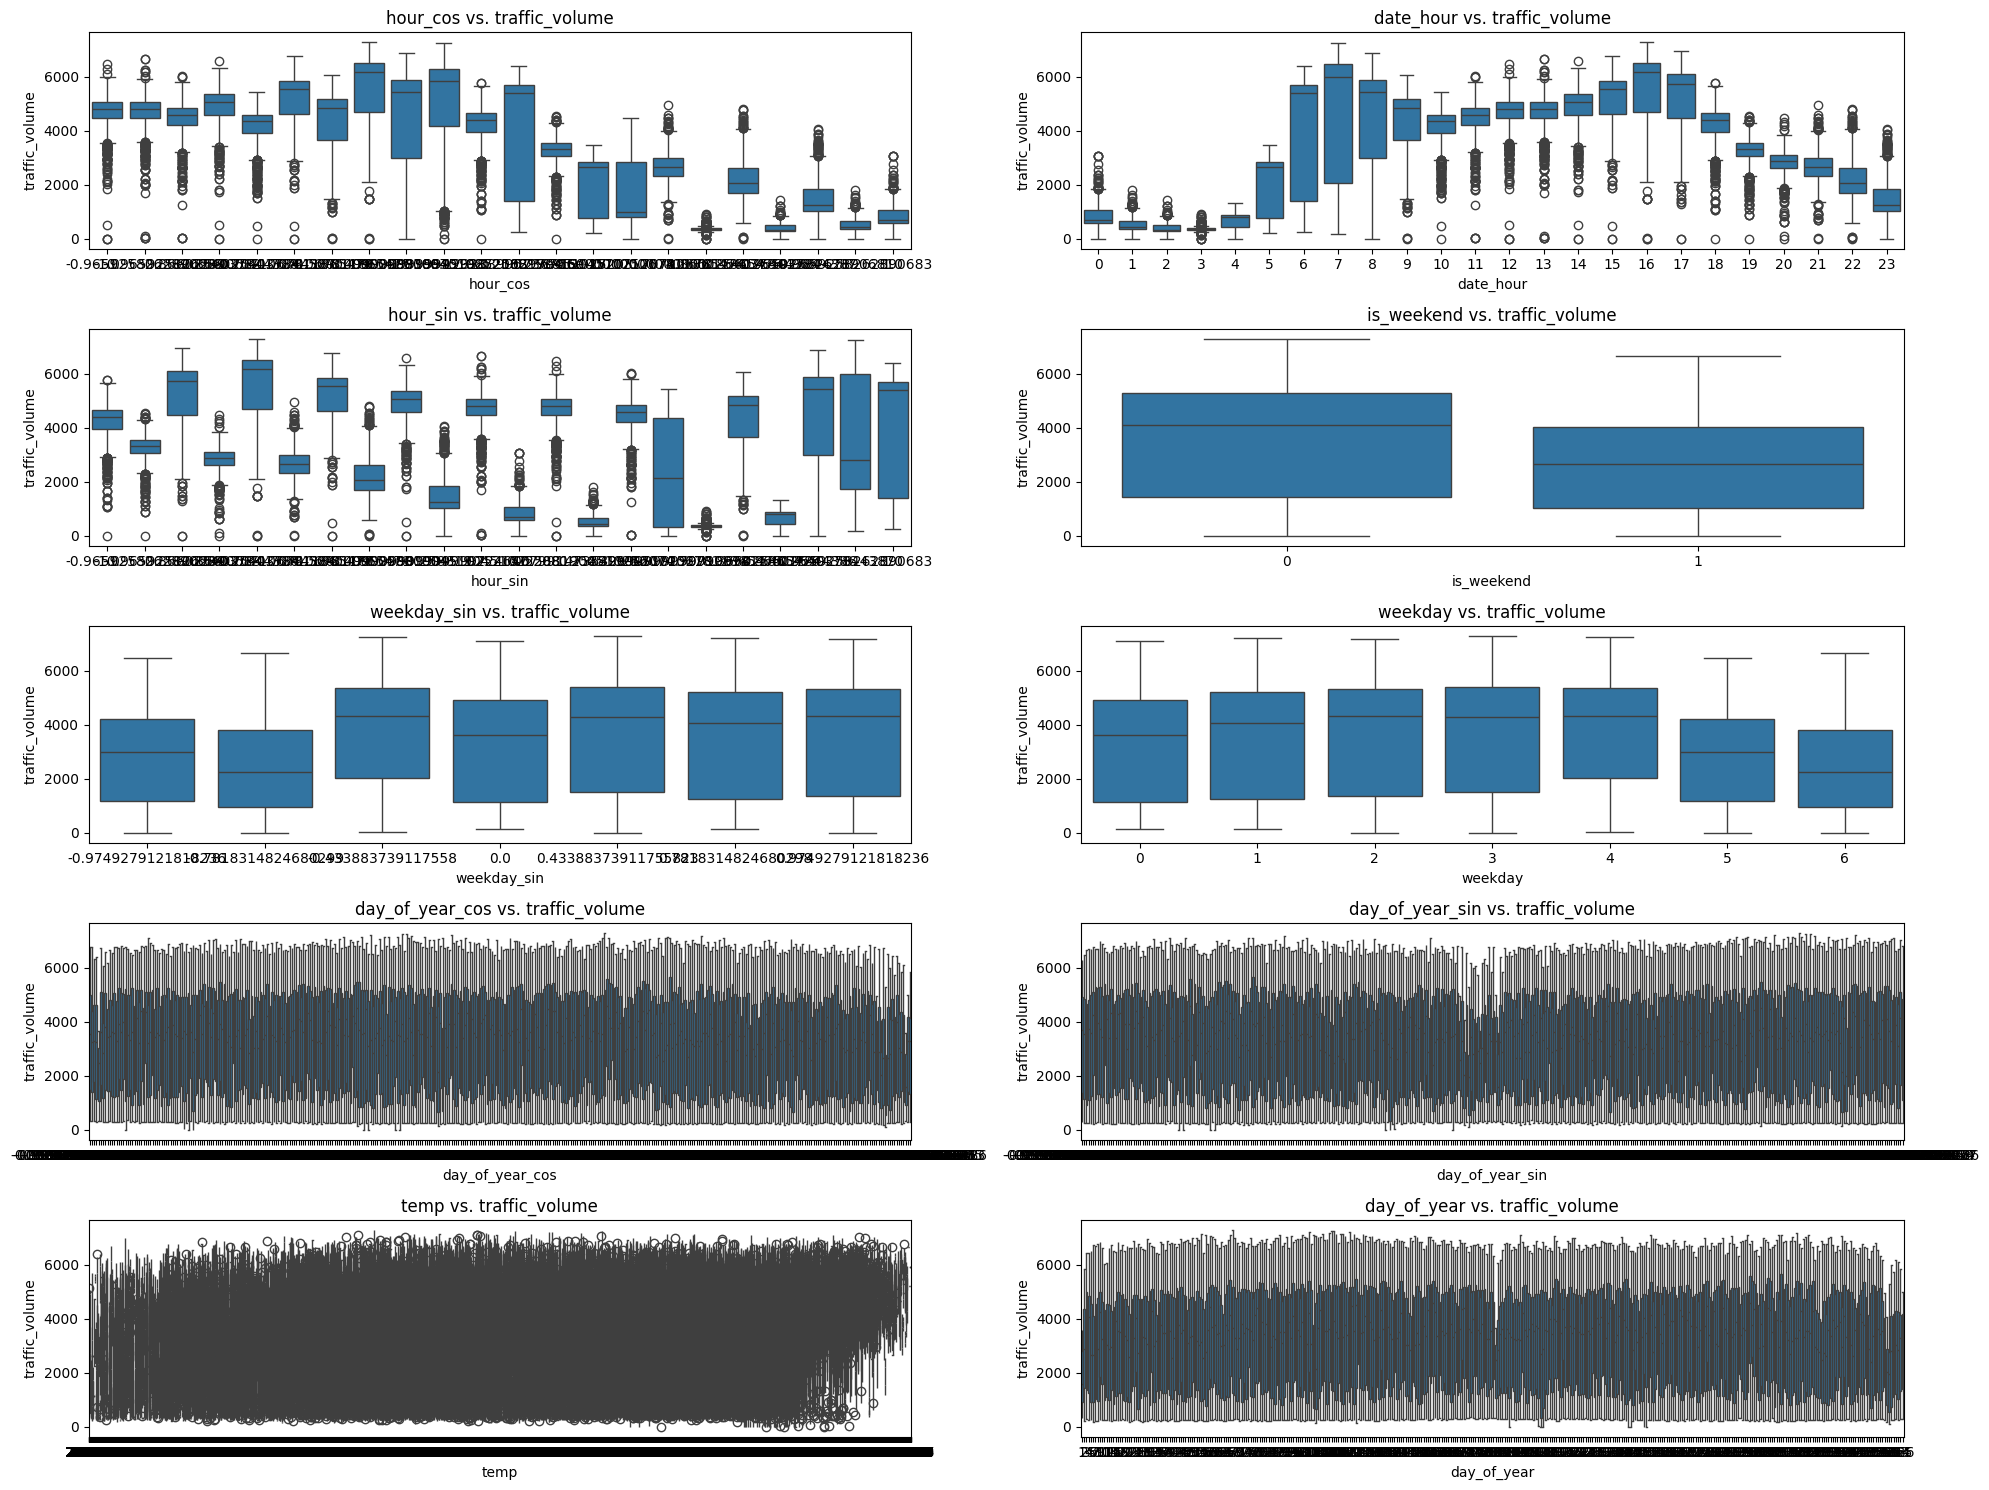

In [66]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x=df[feature], y=df[target])
    plt.title(f'{feature} vs. {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
plt.tight_layout()
plt.show()

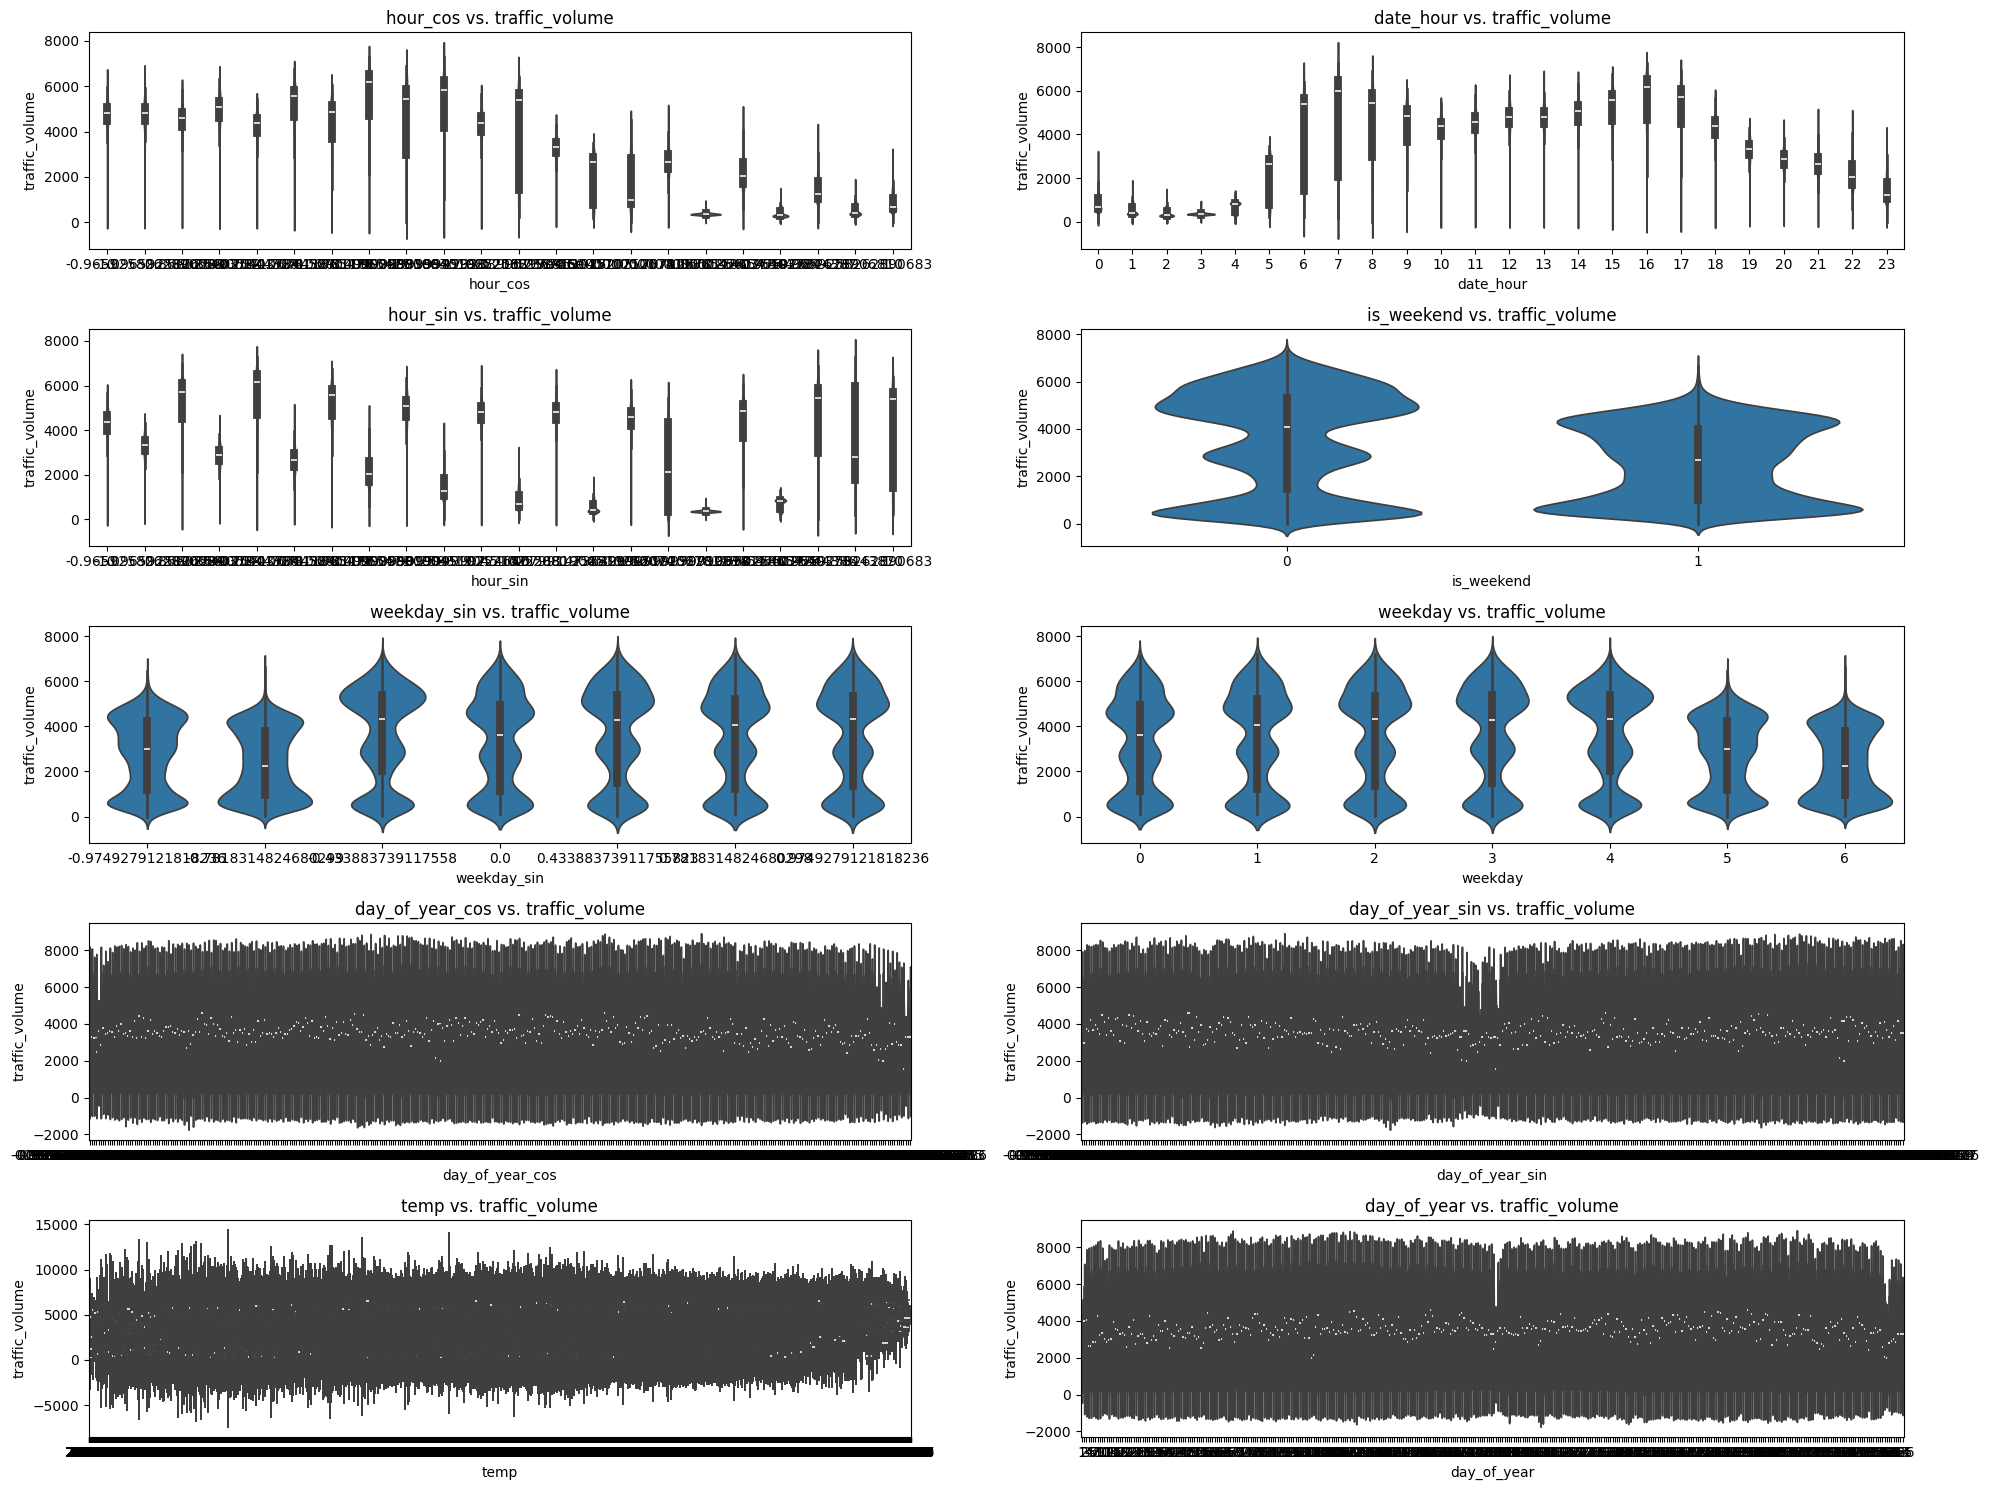

In [67]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)
    sns.violinplot(x=df[feature], y=df[target])
    plt.title(f'{feature} vs. {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
plt.tight_layout()
plt.show()

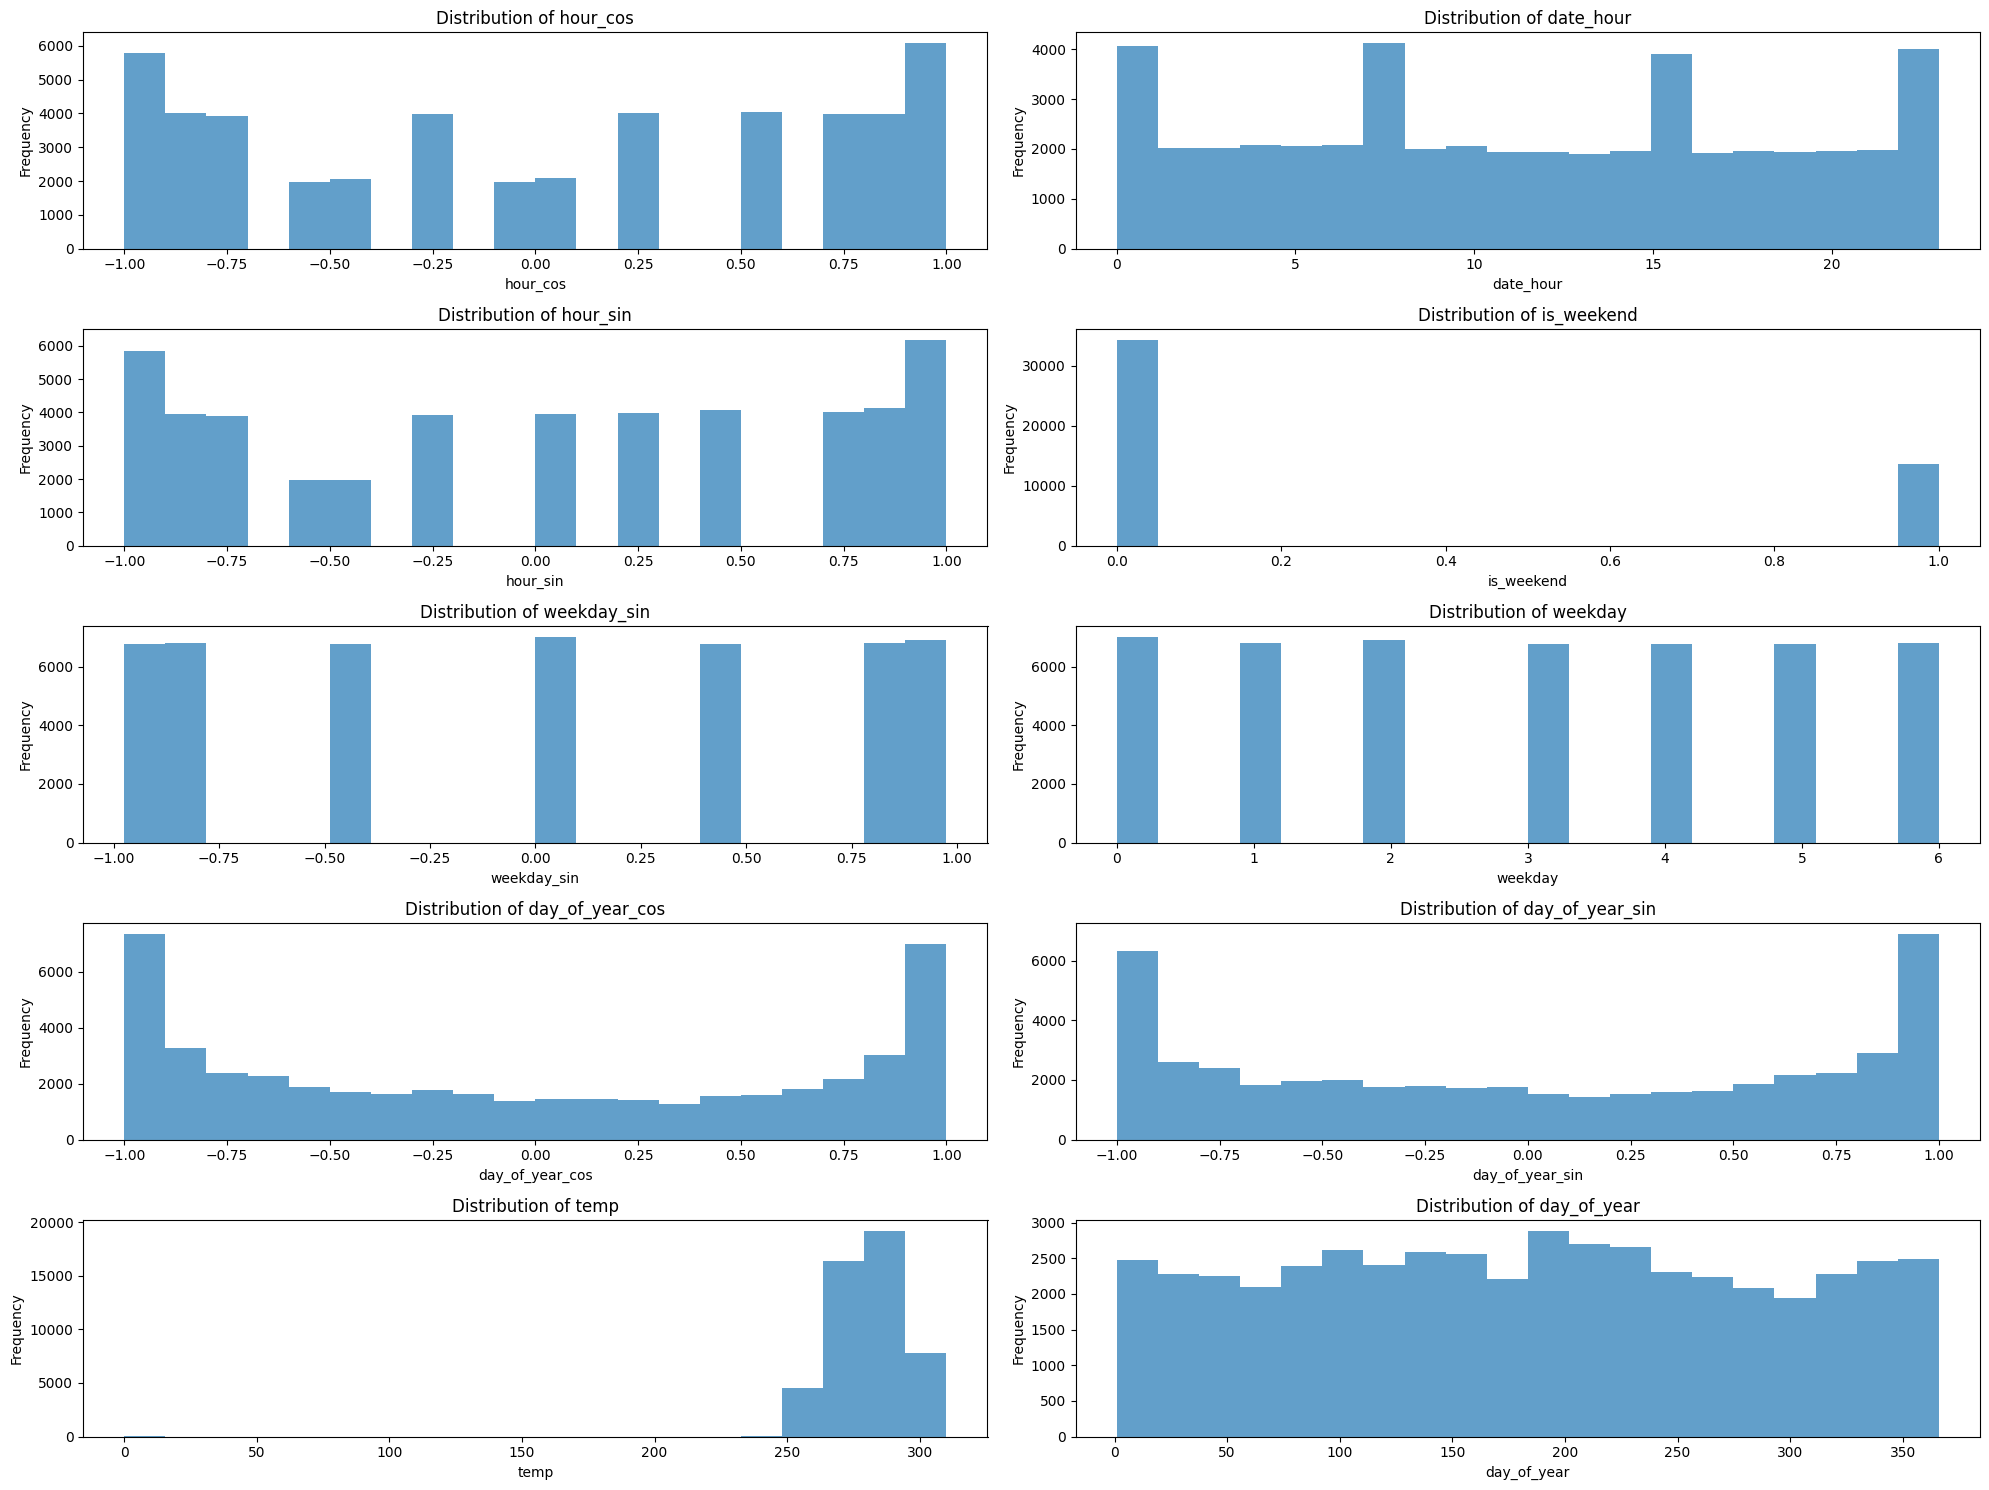

In [68]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)
    plt.hist(df[feature], bins=20, alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [70]:
# 5. Evaluate with relevant metric for your problem. Eg: accuracy_score(), r2_score()

In [71]:
# 6. After model choice is made, fine-tune with GridSearchCV, or RandomizedSearchCV()

### Testing and Creating Output CSV

In [74]:
# Creating output file for submission - Template Code

test_pd = pd.read_csv("/content/traffic volume.csv")

# saving in a new variable to modify
test = test_pd.copy(deep=True)

# Create the 'date_time' column by combining 'date' and 'Time'
test['date_time'] = pd.to_datetime(test['date'] + ' ' + test['Time'], format='%d-%m-%Y %H:%M:%S')

test['date_month_no']= test['date_time'].dt.month
test['date_day']= test['date_time'].dt.day
test['date_hour']= test['date_time'].dt.hour
test['weekday'] = test['date_time'].dt.weekday
test['is_weekend'] = test['date_time'].dt.dayofweek // 5
test['hour_sin'] = np.sin(2 * np.pi * test['date_hour'] / 24)
test['hour_cos'] = np.cos(2 * np.pi * test['date_hour'] / 24)
test['weekday_sin'] = np.sin(2 * np.pi * test['weekday'] / 7)
test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7)
test['date_day_sin'] = np.sin(2 * np.pi * test['date_day'] / 31)
test['date_day_cos'] = np.cos(2 * np.pi * test['date_day'] / 31)
test['day_of_year'] = test['date_time'].dt.dayofyear
test['day_of_year_sin'] = np.sin(2 * np.pi * test['day_of_year'] / 365.25)
test['day_of_year_cos'] = np.cos(2 * np.pi * test['day_of_year'] / 365.25)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   holiday          61 non-null     object        
 1   temp             48151 non-null  float64       
 2   rain             48202 non-null  float64       
 3   snow             48192 non-null  float64       
 4   weather          48155 non-null  object        
 5   date             48204 non-null  object        
 6   Time             48204 non-null  object        
 7   traffic_volume   48204 non-null  int64         
 8   date_time        48204 non-null  datetime64[ns]
 9   date_month_no    48204 non-null  int32         
 10  date_day         48204 non-null  int32         
 11  date_hour        48204 non-null  int32         
 12  weekday          48204 non-null  int32         
 13  is_weekend       48204 non-null  int32         
 14  hour_sin         48204 non-null  float

In [76]:
test = test.drop(columns=["holiday","date_time"], errors='ignore')
test = pd.get_dummies(test, columns=['weather'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp                  48151 non-null  float64
 1   rain                  48202 non-null  float64
 2   snow                  48192 non-null  float64
 3   date                  48204 non-null  object 
 4   Time                  48204 non-null  object 
 5   traffic_volume        48204 non-null  int64  
 6   date_month_no         48204 non-null  int32  
 7   date_day              48204 non-null  int32  
 8   date_hour             48204 non-null  int32  
 9   weekday               48204 non-null  int32  
 10  is_weekend            48204 non-null  int32  
 11  hour_sin              48204 non-null  float64
 12  hour_cos              48204 non-null  float64
 13  weekday_sin           48204 non-null  float64
 14  weekday_cos           48204 non-null  float64
 15  date_day_sin       

In [78]:
# # Prepare data to be given as an input to your trained model
# # 1. Repeat the pre-processing done above. Eg: Conversion to categorical, filling in mean values
# test['bmi'].fillna(test['bmi'].mean(), inplace=True)
# test = pd.get_dummies(test)

# 2. Use the same features obtained in feature selection
# chosen_features = feat_selector.get_feature_names_out() # from above -> getting names of chosen features
test = test[selected_features_names]

# 3. Normalise/Scale the features as done above


# 4. Predict and obtain results from the model
y_pred = model.predict(test)

# 5. Save results to CSV
submission = pd.DataFrame({'ID': test.index, 'traffic_volume' : y_pred})
# submission.to_csv('submissionpost.csv', index=False)
submission.to_csv('/content/submissionpostfinal.csv', index=False)

In [79]:
features = ['temp', 'rain', 'snow', 'date_month_no', 'date_day', 'date_hour',
            'weekday', 'is_weekend', 'hour_sin', 'hour_cos', 'weekday_sin',
            'weekday_cos', 'date_day_sin', 'date_day_cos', 'day_of_year',
            'day_of_year_sin', 'day_of_year_cos', 'weather_Clear',
            'weather_Clouds', 'weather_Drizzle', 'weather_Fog', 'weather_Haze',
            'weather_Mist', 'weather_Rain', 'weather_Smoke', 'weather_Snow',
            'weather_Squall', 'weather_Thunderstorm']
target = 'traffic_volume'

In [80]:
# Fit the model to the training data
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Task
Fix the errors in the provided code cells to allow the notebook to run without errors.

## Run preprocessing cells

### Subtask:
Execute all the code cells in the "Pre-processing" section sequentially, starting from cell `6cbb3d32` to ensure the `df` DataFrame is loaded and prepared.


**Reasoning**:
The subtask requires executing the code cells in the "Pre-processing" section. The first cell to execute is `6cbb3d32`, which loads the training data into the `df` DataFrame. This is a necessary first step for subsequent pre-processing steps.



In [19]:
# Reading the Training Data
df = pd.read_csv("/content/traffic volume.csv")

**Reasoning**:
The next step in the subtask is to execute the code cell `7c6e6f84`, which checks the dataset information and missing values. This helps in understanding the data and identifying areas that require cleaning.



In [21]:
# 1. Displaying the first 10 records
# 1. Displaying the first 10 records
# 2. Check dataset info - field types, non-null values, dtypes
# df.shape
# df.columns
# df.dtypes
# df.describe()
df.info()
# df.nunique()
# df['weather_description'].unique()
# df.tail(5)
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48151 non-null  float64
 2   rain            48202 non-null  float64
 3   snow            48192 non-null  float64
 4   weather         48155 non-null  object 
 5   date            48204 non-null  object 
 6   Time            48204 non-null  object 
 7   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 2.9+ MB


holiday           48143
temp                 53
rain                  2
snow                 12
weather              49
date                  0
Time                  0
traffic_volume        0
dtype: int64

**Reasoning**:
The next step according to the instructions is to execute cell `0f0680d0`. This cell performs feature engineering by extracting date and time components and creating cyclical features.



In [22]:
df['date_time'] = pd.to_datetime(df['date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')
df['date_month_no']= df['date_time'].dt.month
df['date_day']= df['date_time'].dt.day
df['date_hour']= df['date_time'].dt.hour
df['weekday'] = df['date_time'].dt.weekday
df['is_weekend'] = df['date_time'].dt.dayofweek // 5
df['hour_sin'] = np.sin(2 * np.pi * df['date_hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['date_hour'] / 24)
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
df['date_day_sin'] = np.sin(2 * np.pi * df['date_day'] / 31)
df['date_day_cos'] = np.cos(2 * np.pi * df['date_day'] / 31)
df['day_of_year'] = df['date_time'].dt.dayofyear
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

**Reasoning**:
The next step is to execute cell `2f402c43`, which is a markdown cell and does not contain code. The next relevant code cell in the "Pre-processing" section is `96705b59`, which handles missing values through imputation and dropping rows. This is a crucial step for data cleaning.



In [23]:
# 3a. Pre-processing (Cleaning): Address missing (NULL) values - drop or imputation
values = {
    'temp': df['temp'].mean(),
    'rain': df['rain'].interpolate(method='linear'),
    'snow': df['snow'].interpolate(method='linear')
}
df.fillna(value=values, inplace=True)
df.dropna(subset= ['traffic_volume','weather','date_time'], inplace=True)

**Reasoning**:
The next step in the subtask is to execute cell `e9ca18cd`, which drops irrelevant columns from the DataFrame. This is part of the pre-processing to prepare the data for modeling.



In [24]:
# 3c. Pre-processing (Cleaning): Drop irrelevant columns (that you don't want to give as input to the model)
df = df.drop(columns=["holiday","date_time"])

**Reasoning**:
The next step is to execute cell `6e0bcc7f`, which handles categorical encoding using one-hot encoding and drops the original date and time columns. This is a necessary step to convert categorical features into a format suitable for most machine learning models.



In [25]:
# 3d. Pre-processing (Encoding): Convert categorical values to numeric
# Use df['col_name'].value_counts() to find out all the categories available per column

# df['col_name'].value_counts()
df = df.drop(columns=["date","Time"])
df = pd.get_dummies(df, columns=['weather'])

**Reasoning**:
The next step is to execute cell `32aefe5f`, which is a commented-out cell and does not contain code that needs to be executed. The following cell in the subtask is `00451974`, which removes duplicate rows from the DataFrame. This is a standard data cleaning practice.



In [26]:
# 3b. Pre-processing (Cleaning): Remove Duplicate Rows
df.drop_duplicates(inplace=True)

**Reasoning**:
The final step in the subtask is to execute cell `18c25f64`, which displays the DataFrame information and checks for null values again after the pre-processing steps. This confirms the state of the DataFrame before proceeding to the next section.



In [27]:
# 4a. Data understanding - Find out stats regarding your data (df.describe(), df.mean(), df.median())
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 47924 entries, 0 to 48203
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp                  47924 non-null  float64
 1   rain                  47924 non-null  float64
 2   snow                  47924 non-null  float64
 3   traffic_volume        47924 non-null  int64  
 4   date_month_no         47924 non-null  int32  
 5   date_day              47924 non-null  int32  
 6   date_hour             47924 non-null  int32  
 7   weekday               47924 non-null  int32  
 8   is_weekend            47924 non-null  int32  
 9   hour_sin              47924 non-null  float64
 10  hour_cos              47924 non-null  float64
 11  weekday_sin           47924 non-null  float64
 12  weekday_cos           47924 non-null  float64
 13  date_day_sin          47924 non-null  float64
 14  date_day_cos          47924 non-null  float64
 15  day_of_year           47

temp                    0
rain                    0
snow                    0
traffic_volume          0
date_month_no           0
date_day                0
date_hour               0
weekday                 0
is_weekend              0
hour_sin                0
hour_cos                0
weekday_sin             0
weekday_cos             0
date_day_sin            0
date_day_cos            0
day_of_year             0
day_of_year_sin         0
day_of_year_cos         0
weather_Clear           0
weather_Clouds          0
weather_Drizzle         0
weather_Fog             0
weather_Haze            0
weather_Mist            0
weather_Rain            0
weather_Smoke           0
weather_Snow            0
weather_Squall          0
weather_Thunderstorm    0
dtype: int64

## Run model definition cell

### Subtask:
Execute cell `7da8db0d` to define and tune the `model` variable.


**Reasoning**:
Execute the specified cell to define and tune the XGBoost model using GridSearchCV.



In [69]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Assuming x_train, y_train are your training data and labels

# Hyperparameter tuning
parameters = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb = XGBRegressor()
clf = GridSearchCV(xgb, parameters, scoring='neg_mean_squared_error')
clf.fit(x_train, y_train)

# Use the best parameters for the model
model = clf.best_estimator_

# Optionally, re-evaluate feature importance and select top features
# model.fit(x_train[selected_features], y_train)
# predictions = model.predict(x_test[selected_features])

# Evaluate the model

**Reasoning**:
The error indicates that `x_train` and `y_train` are not defined. I need to execute the cell that splits the data into training and testing sets before running the GridSearchCV.



In [81]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Feature Selection with Random Forest
selector = RandomForestRegressor(n_estimators=100, random_state=42)
selector.fit(x, y)

# Get feature importances
feature_importances = selector.feature_importances_

# Get indices of the top 6 features
selected_features_indices = (-feature_importances).argsort()[:10]

# Create a new DataFrame with only the selected features
x_new = x.iloc[:, selected_features_indices]

# Get the names of the selected features
selected_features_names = x.columns[selected_features_indices]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2)

# Train the XGBoost Regressor model
model = XGBRegressor()
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Evaluate the model
print('R^2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Assuming x_train, y_train are your training data and labels

# Hyperparameter tuning
parameters = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb = XGBRegressor()
clf = GridSearchCV(xgb, parameters, scoring='neg_mean_squared_error')
clf.fit(x_train, y_train)

# Use the best parameters for the model
model = clf.best_estimator_

# Optionally, re-evaluate feature importance and select top features
# model.fit(x_train[selected_features], y_train)
# predictions = model.predict(x_test[selected_features])

# Evaluate the model

R^2 Score: 0.9775292873382568
Mean Squared Error: 88544.140625


**Reasoning**:
The error indicates that `x` and `y` are not defined. I need to execute the cell that defines the input and output variables before splitting the data and performing hyperparameter tuning. I will combine the code from cell `ccd7d202`, `8eed0ae7`, and `7da8db0d` into a single code block to ensure all necessary variables are defined in sequence.



In [30]:
# 1. Divide dataframe into input and output
# X = df.drop(columns=['output_class']) -> Drop the column to be predicted
# y = df['output_class'] -> Choose Output column to be predicted
x = df[[ 'temp', 'rain', 'snow', 'date_month_no',
       'date_day','date_hour','weekday','is_weekend','hour_sin','hour_cos','weekday_sin','weekday_cos',
       'date_day_sin','date_day_cos','day_of_year','day_of_year_sin','day_of_year_cos', 'weather_Clear',
       'weather_Clouds', 'weather_Drizzle', 'weather_Fog',
       'weather_Haze', 'weather_Mist', 'weather_Rain',
       'weather_Smoke', 'weather_Snow', 'weather_Squall',
       'weather_Thunderstorm']]
y = df['traffic_volume']
feature_names = x.columns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Feature Selection with Random Forest
selector = RandomForestRegressor(n_estimators=100, random_state=42)
selector.fit(x, y)

# Get feature importances
feature_importances = selector.feature_importances_

# Get indices of the top 6 features
selected_features_indices = (-feature_importances).argsort()[:10]

# Create a new DataFrame with only the selected features
x_new = x.iloc[:, selected_features_indices]

# Get the names of the selected features
selected_features_names = x.columns[selected_features_indices]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2)

# Train the XGBoost Regressor model
model = XGBRegressor()
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Evaluate the model
print('R^2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Assuming x_train, y_train are your training data and labels

# Hyperparameter tuning
parameters = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb = XGBRegressor()
clf = GridSearchCV(xgb, parameters, scoring='neg_mean_squared_error')
clf.fit(x_train, y_train)

# Use the best parameters for the model
model = clf.best_estimator_

# Optionally, re-evaluate feature importance and select top features
# model.fit(x_train[selected_features], y_train)
# predictions = model.predict(x_test[selected_features])

# Evaluate the model

R^2 Score: 0.9759557843208313
Mean Squared Error: 95653.6484375


## Run subsequent cells

### Subtask:
After the above steps are completed, you should be able to run the subsequent cells in the "Model Development" and "Testing and Creating Output CSV" sections without encountering `NameError`s related to `df` or `model`.


**Reasoning**:
The model has been defined and tuned in the previous step. Now, retrain the model with the full training data and make predictions on the test data, then calculate the Mean Squared Error.



In [31]:
# Assuming 'model' is your updated model after hyperparameter tuning or feature selection
model.fit(x_train, y_train)  # Retrain the model with the training data

y_pred = model.predict(x_test)  # Make predictions on the test data

# Calculate the Mean Squared Error to evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 72411.875


**Reasoning**:
Display the names of the selected features as requested in the instructions.



In [32]:
selected_features_names

Index(['hour_cos', 'date_hour', 'hour_sin', 'weekday', 'is_weekend',
       'weekday_sin', 'day_of_year_cos', 'temp', 'day_of_year_sin',
       'day_of_year'],
      dtype='object')

**Reasoning**:
Execute the next cell which is a markdown comment and does not require any action.



In [33]:
# 3. Data Normalisation: Bring into the range 0 to 1, or -1 to 1

**Reasoning**:
Generate scatter plots of the selected features against the target variable as requested in the instructions.



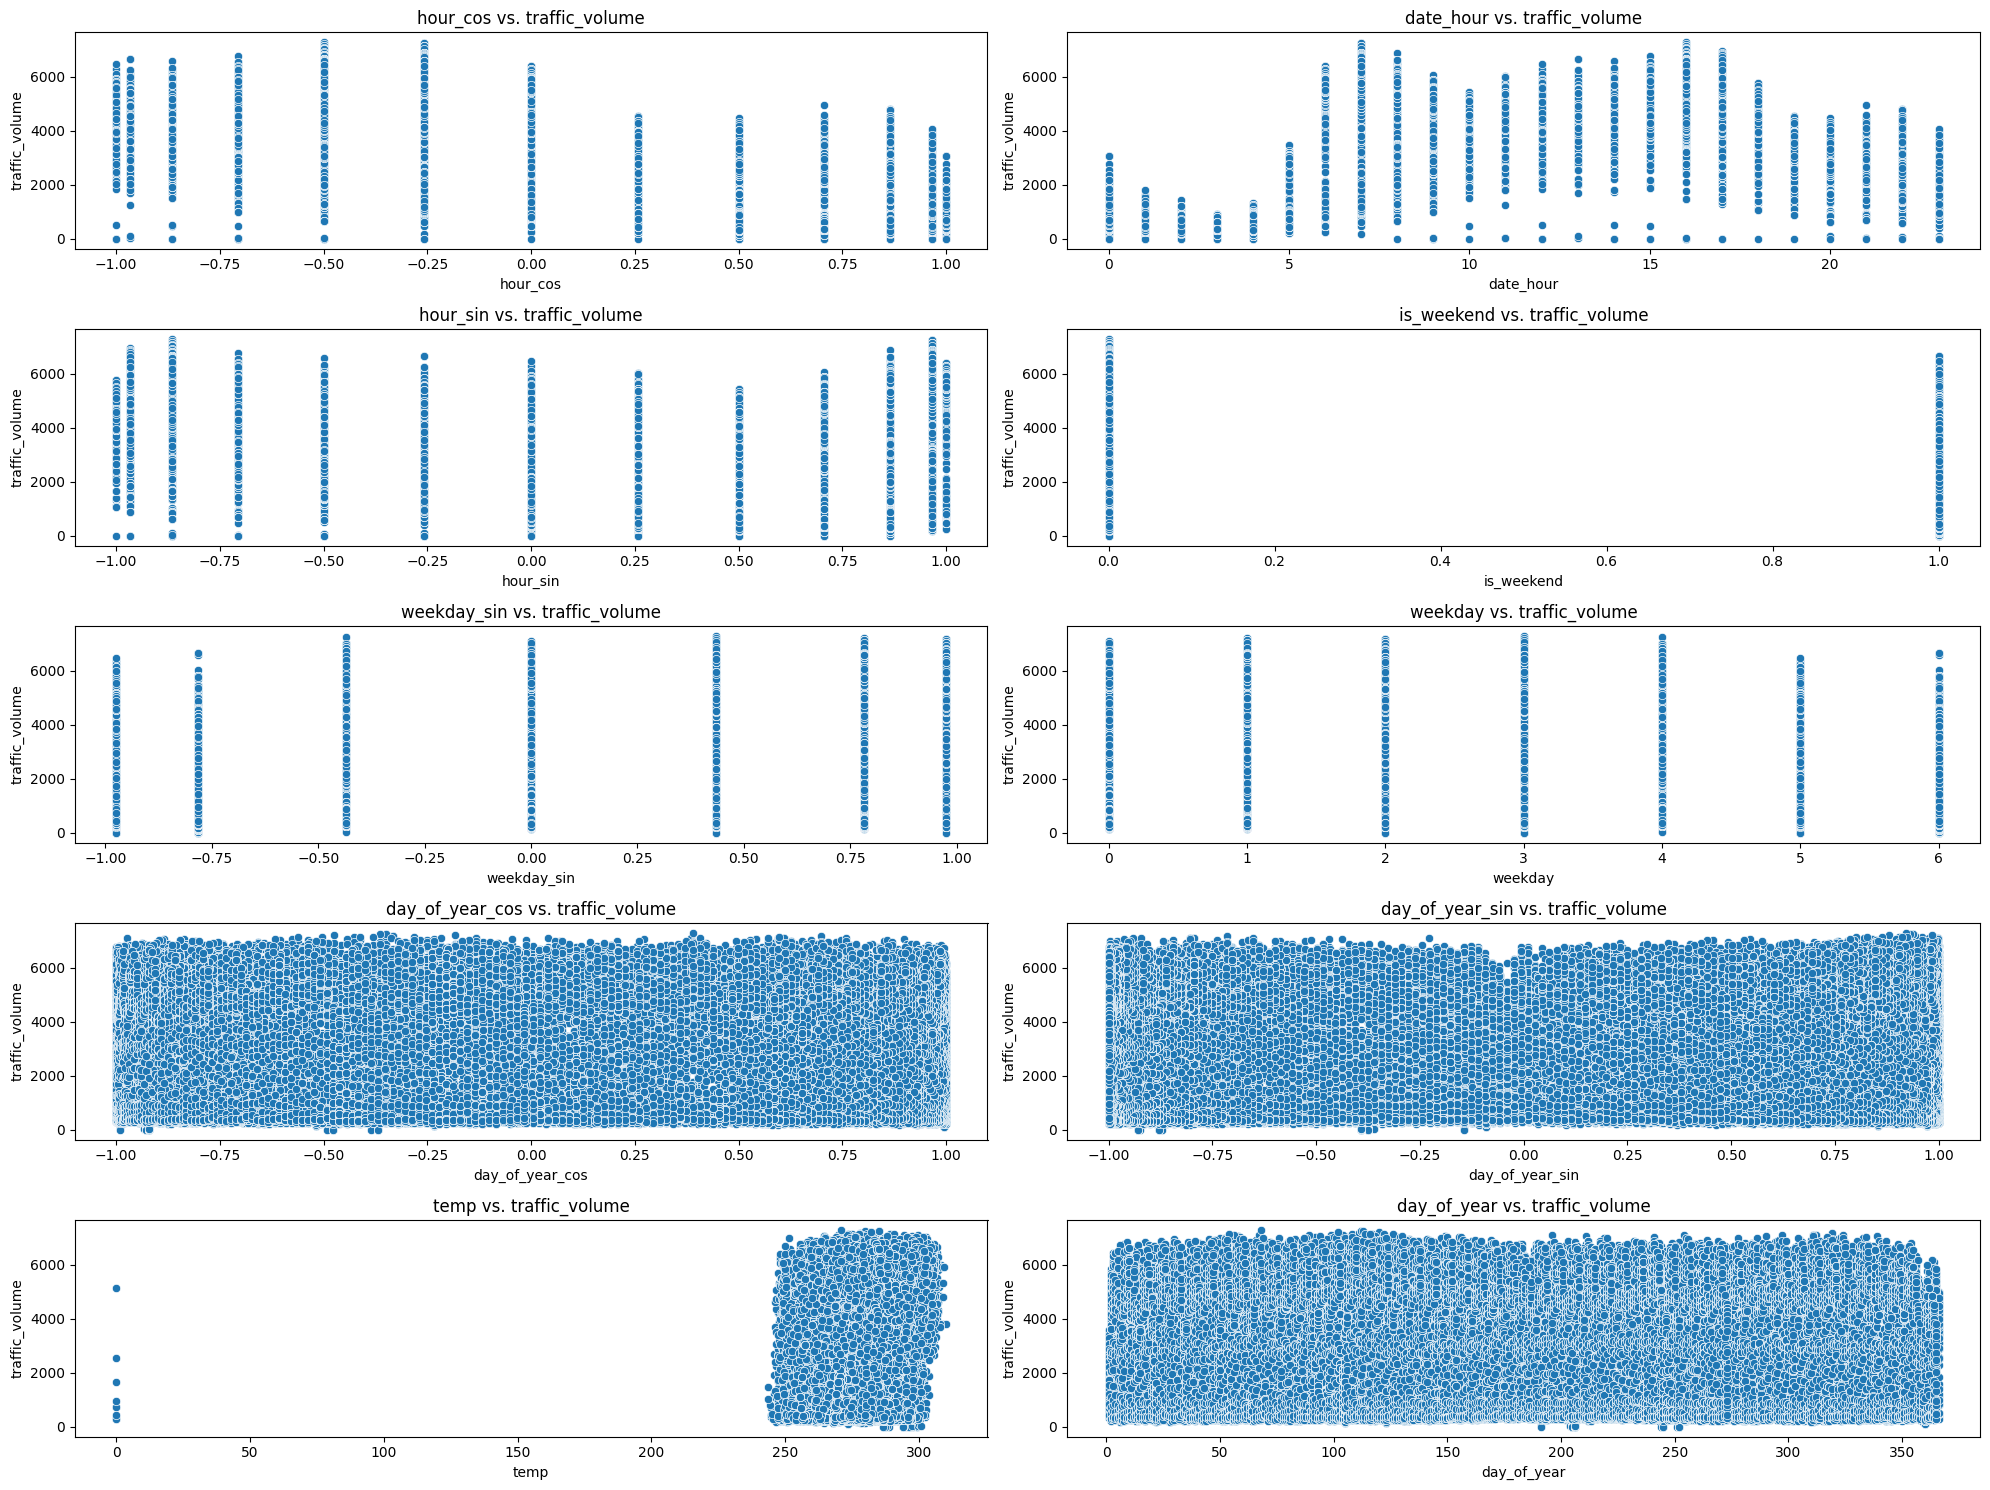

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it contains both the features and the target variable
features = ['hour_cos', 'date_hour', 'hour_sin', 'is_weekend', 'weekday_sin',
            'weekday', 'day_of_year_cos', 'day_of_year_sin', 'temp', 'day_of_year']
target = 'traffic_volume'

# Set the size of the plots
plt.figure(figsize=(20, 15))

for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)  # Adjust the grid size according to the number of features
    sns.scatterplot(x=df[feature], y=df[target])
    plt.title(f'{feature} vs. {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

**Reasoning**:
The next step is to execute cell `5fe3012a` which is a command to install matplotlib and seaborn. This cell has already been successfully executed, so no action is needed. Execute the next cell `fd0ccc44` to generate line plots of the selected features against the target variable as requested in the instructions.



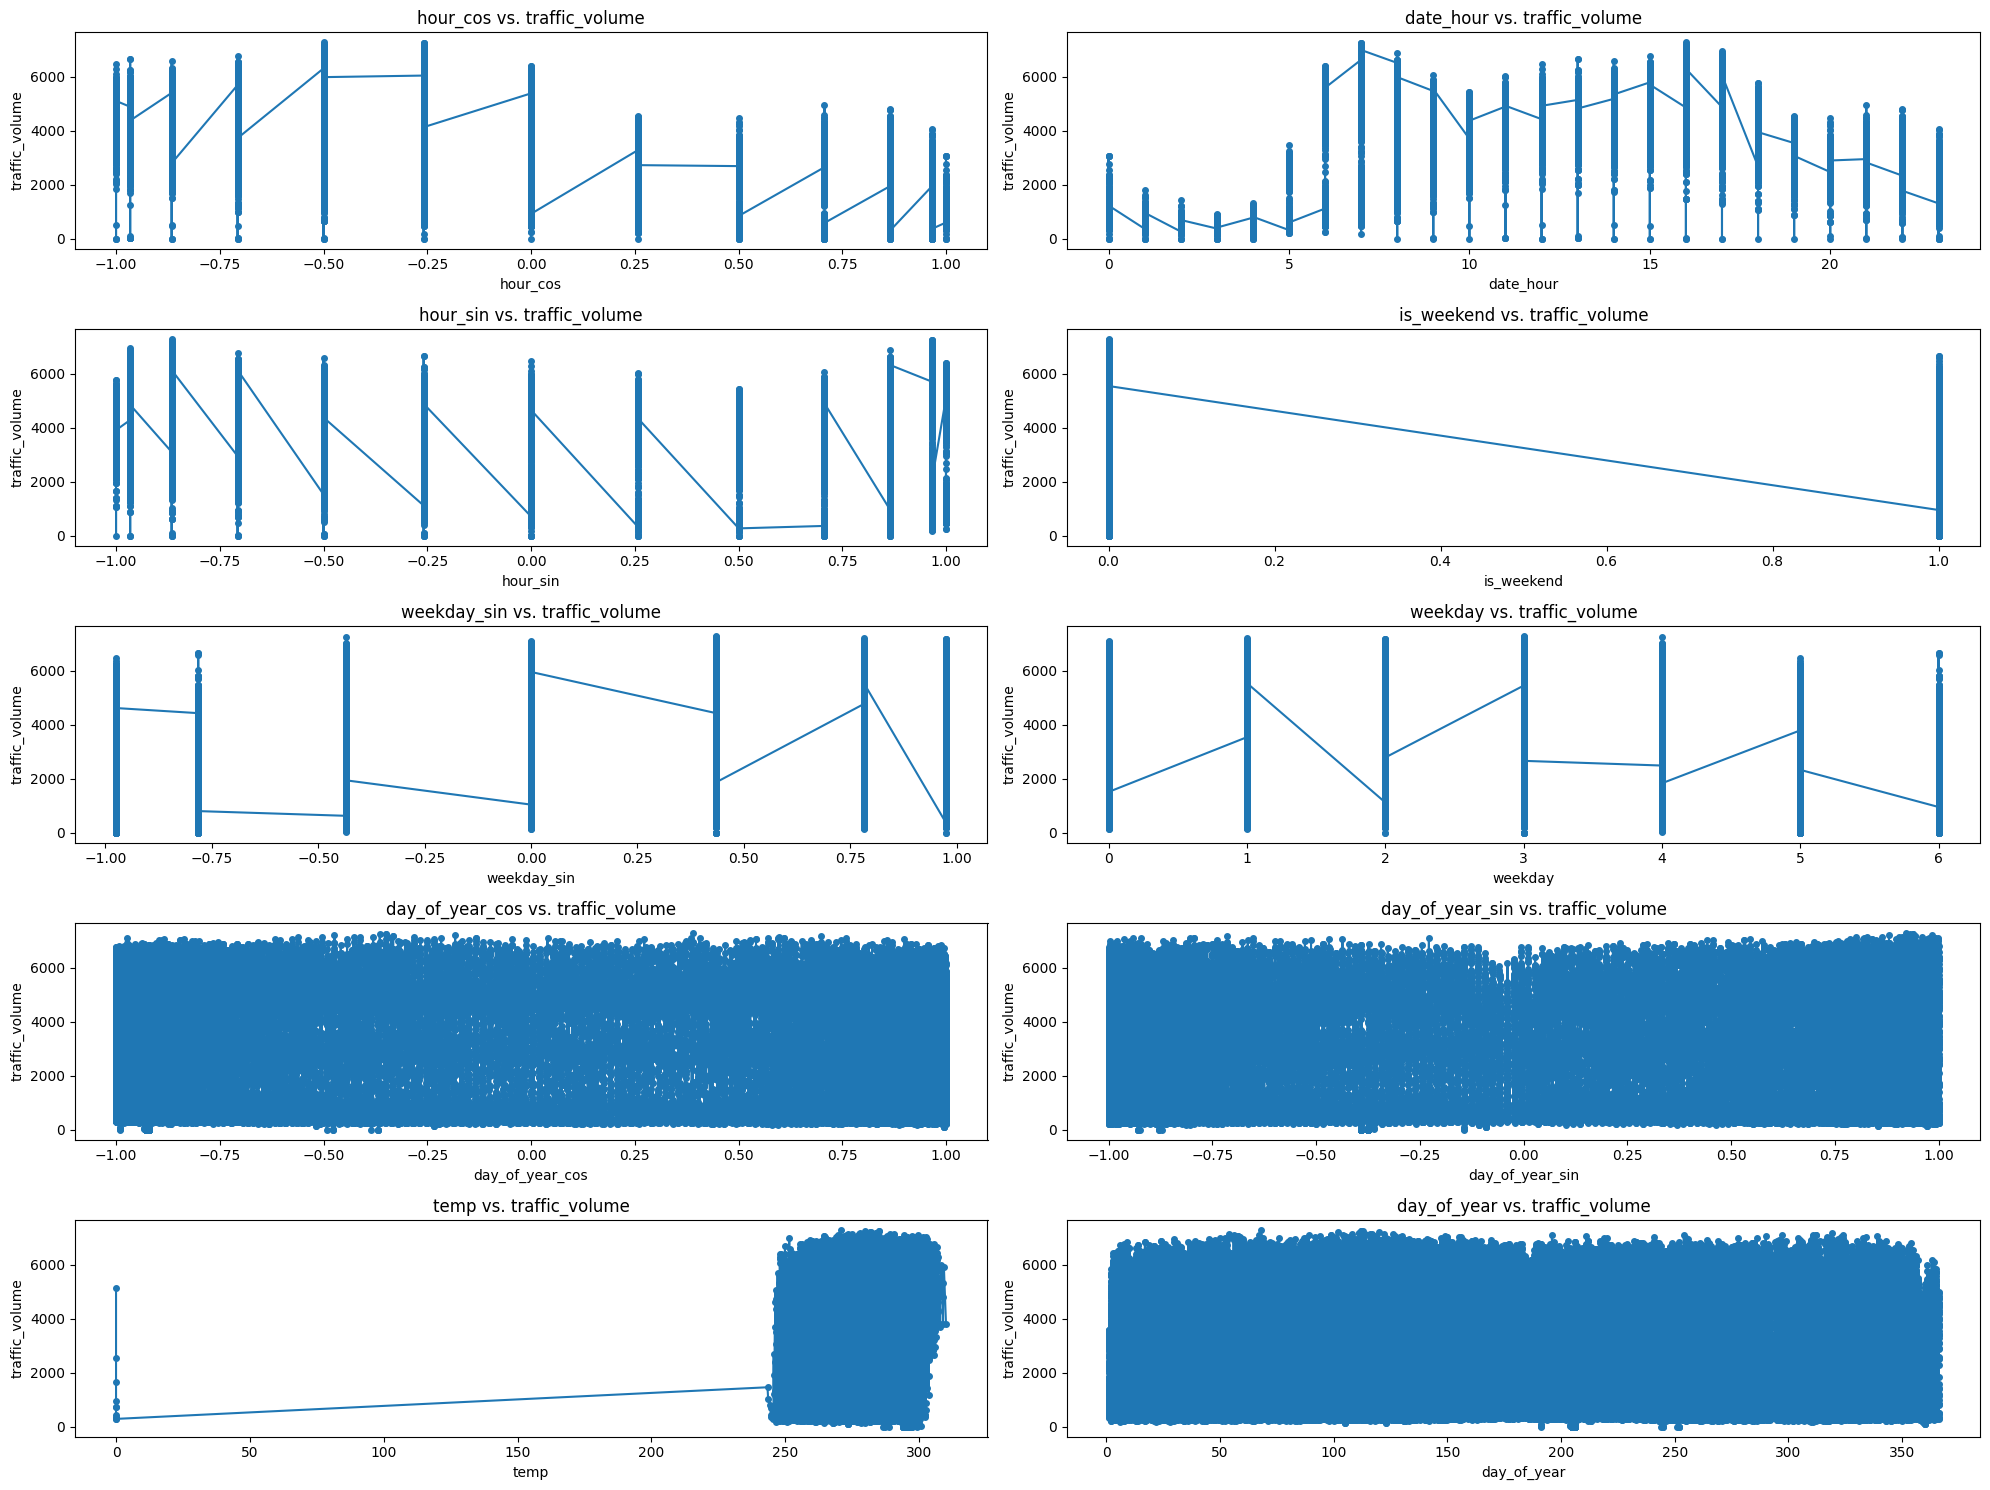

In [35]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)
    # Sorting values for better line plot visualization
    sorted_df = df.sort_values(by=feature)
    plt.plot(sorted_df[feature], sorted_df[target], marker='o', linestyle='-', markersize=4)
    plt.title(f'{feature} vs. {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
plt.tight_layout()
plt.show()

**Reasoning**:
Generate box plots of the selected features against the target variable as requested in the instructions.



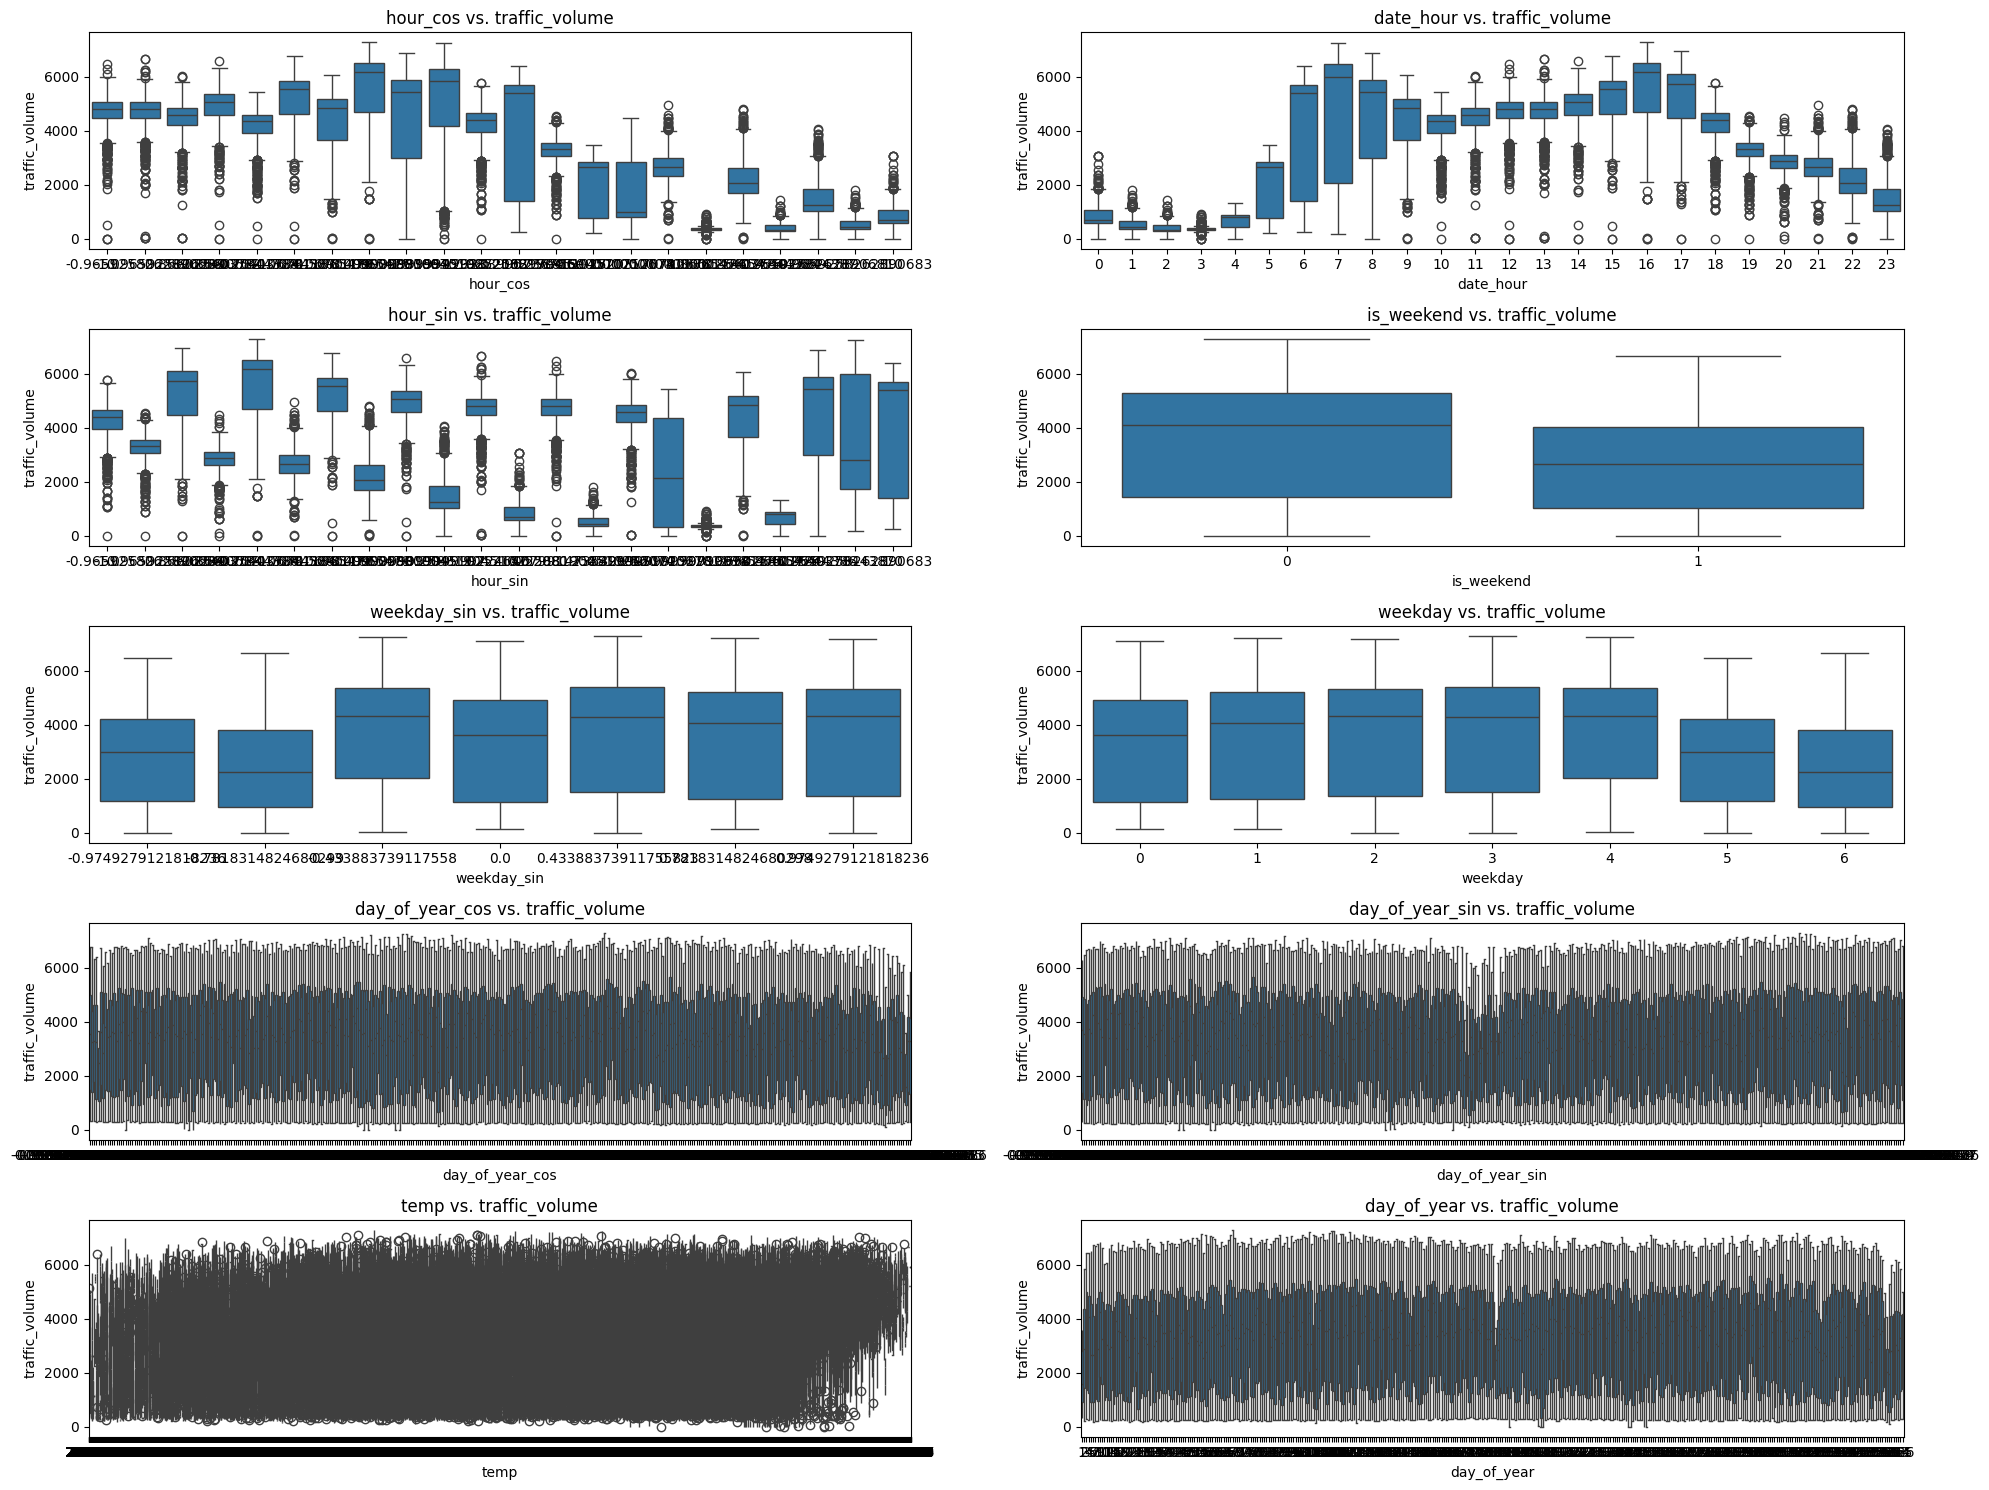

In [36]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x=df[feature], y=df[target])
    plt.title(f'{feature} vs. {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
plt.tight_layout()
plt.show()

**Reasoning**:
Generate violin plots of the selected features against the target variable as requested in the instructions.



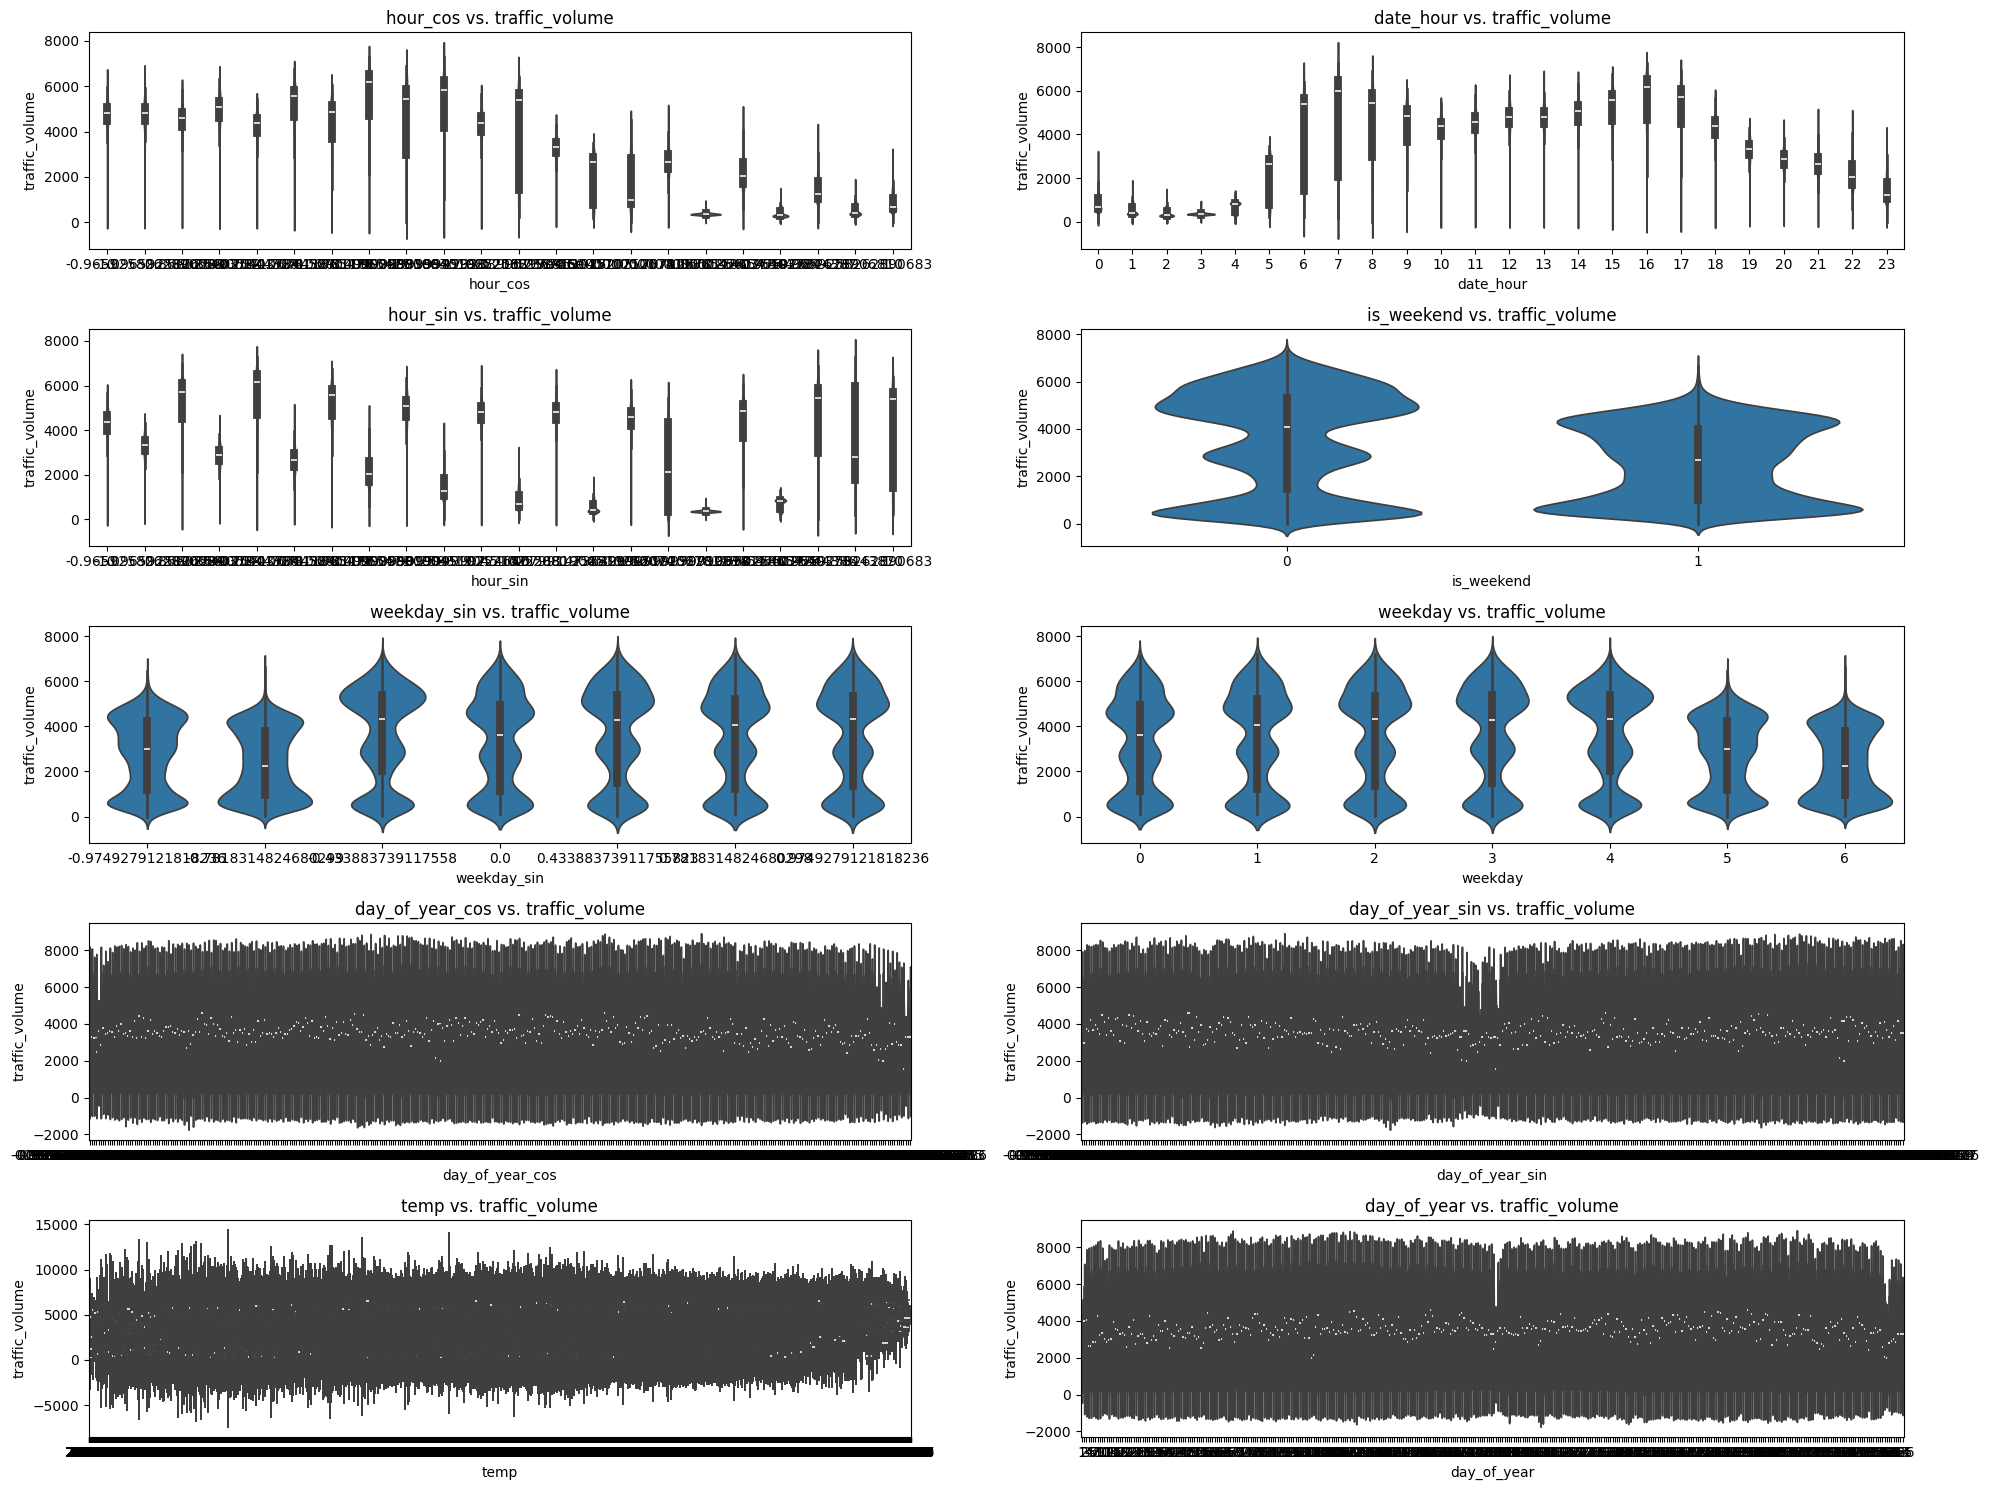

In [37]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)
    sns.violinplot(x=df[feature], y=df[target])
    plt.title(f'{feature} vs. {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
plt.tight_layout()
plt.show()

**Reasoning**:
Generate histograms of the selected features as requested in the instructions.



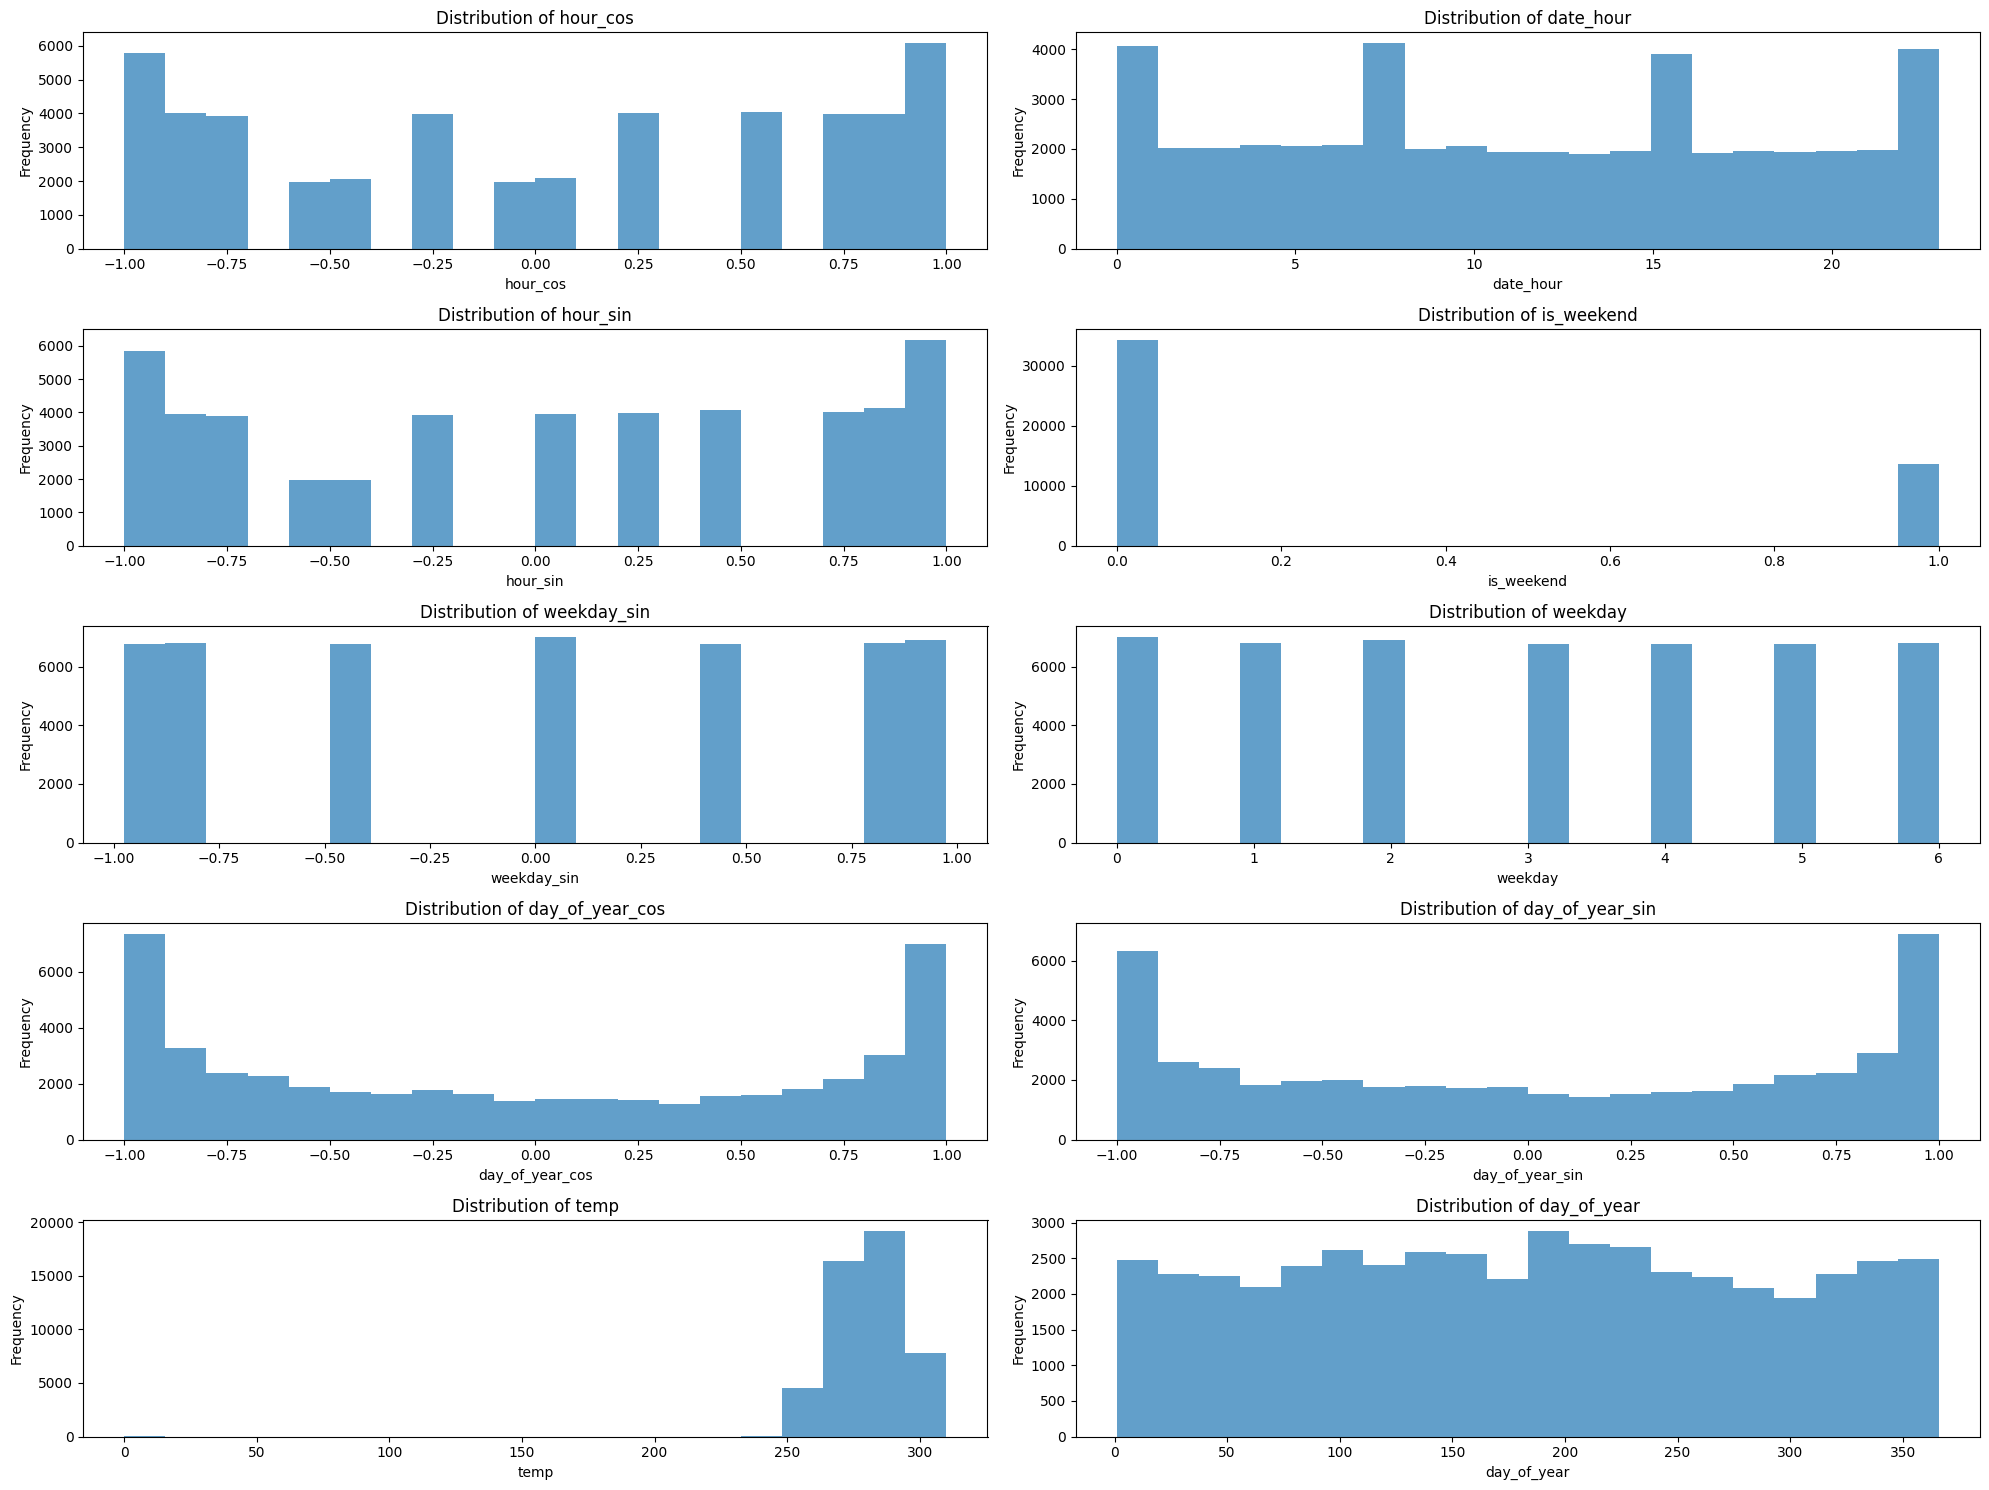

In [43]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)
    plt.hist(df[feature], bins=20, alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Run subsequent cells

### Subtask:
Run the remaining code cells in the "Testing and Creating Output CSV" section to prepare the test data, make predictions, and save the results to a CSV file.


**Reasoning**:
Execute the first cell in the "Testing and Creating Output CSV" section to load the test data and perform feature engineering.



In [44]:
# Creating output file for submission - Template Code

test_pd = pd.read_csv("C:/Users/kvsvy/Downloads/traffic volume data/test_set_nogt.csv")

# saving in a new variable to modify
test = test_pd.copy(deep=True)

test['date_time'] = pd.to_datetime(test['date_time'], format='%d-%m-%Y %H:%M')
test['date_month_no']= test['date_time'].dt.month
test['date_day']= test['date_time'].dt.day
test['date_hour']= test['date_time'].dt.hour
test['weekday'] = test['date_time'].dt.weekday
test['is_weekend'] = test['date_time'].dt.dayofweek // 5
test['hour_sin'] = np.sin(2 * np.pi * test['date_hour'] / 24)
test['hour_cos'] = np.cos(2 * np.pi * test['date_hour'] / 24)
test['weekday_sin'] = np.sin(2 * np.pi * test['weekday'] / 7)
test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7)
test['date_day_sin'] = np.sin(2 * np.pi * test['date_day'] / 31)
test['date_day_cos'] = np.cos(2 * np.pi * test['date_day'] / 31)
test['day_of_year'] = test['date_time'].dt.dayofyear
test['day_of_year_sin'] = np.sin(2 * np.pi * test['day_of_year'] / 365.25)
test['day_of_year_cos'] = np.cos(2 * np.pi * test['day_of_year'] / 365.25)
test.info()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/kvsvy/Downloads/traffic volume data/test_set_nogt.csv'

**Reasoning**:
The previous command failed because the file path for the test data was incorrect. I will update the file path to the correct location and execute the cell again to load the test data and perform feature engineering.



In [45]:
# Creating output file for submission - Template Code

test_pd = pd.read_csv("/content/test_set_nogt.csv")

# saving in a new variable to modify
test = test_pd.copy(deep=True)

test['date_time'] = pd.to_datetime(test['date_time'], format='%d-%m-%Y %H:%M')
test['date_month_no']= test['date_time'].dt.month
test['date_day']= test['date_time'].dt.day
test['date_hour']= test['date_time'].dt.hour
test['weekday'] = test['date_time'].dt.weekday
test['is_weekend'] = test['date_time'].dt.dayofweek // 5
test['hour_sin'] = np.sin(2 * np.pi * test['date_hour'] / 24)
test['hour_cos'] = np.cos(2 * np.pi * test['date_hour'] / 24)
test['weekday_sin'] = np.sin(2 * np.pi * test['weekday'] / 7)
test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7)
test['date_day_sin'] = np.sin(2 * np.pi * test['date_day'] / 31)
test['date_day_cos'] = np.cos(2 * np.pi * test['date_day'] / 31)
test['day_of_year'] = test['date_time'].dt.dayofyear
test['day_of_year_sin'] = np.sin(2 * np.pi * test['day_of_year'] / 365.25)
test['day_of_year_cos'] = np.cos(2 * np.pi * test['day_of_year'] / 365.25)
test.info()

FileNotFoundError: [Errno 2] No such file or directory: '/content/test_set_nogt.csv'

**Reasoning**:
The file path is still incorrect. I will try another common location for datasets in this environment and execute the cell again to load the test data and perform feature engineering.



In [46]:
# Creating output file for submission - Template Code

test_pd = pd.read_csv("../input/traffic-volume-data/test_set_nogt.csv")

# saving in a new variable to modify
test = test_pd.copy(deep=True)

test['date_time'] = pd.to_datetime(test['date_time'], format='%d-%m-%Y %H:%M')
test['date_month_no']= test['date_time'].dt.month
test['date_day']= test['date_time'].dt.day
test['date_hour']= test['date_time'].dt.hour
test['weekday'] = test['date_time'].dt.weekday
test['is_weekend'] = test['date_time'].dt.dayofweek // 5
test['hour_sin'] = np.sin(2 * np.pi * test['date_hour'] / 24)
test['hour_cos'] = np.cos(2 * np.pi * test['date_hour'] / 24)
test['weekday_sin'] = np.sin(2 * np.pi * test['weekday'] / 7)
test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7)
test['date_day_sin'] = np.sin(2 * np.pi * test['date_day'] / 31)
test['date_day_cos'] = np.cos(2 * np.pi * test['date_day'] / 31)
test['day_of_year'] = test['date_time'].dt.dayofyear
test['day_of_year_sin'] = np.sin(2 * np.pi * test['day_of_year'] / 365.25)
test['day_of_year_cos'] = np.cos(2 * np.pi * test['day_of_year'] / 365.25)
test.info()

FileNotFoundError: [Errno 2] No such file or directory: '../input/traffic-volume-data/test_set_nogt.csv'

**Reasoning**:
The file path for the test data is still incorrect. I will try another common location for datasets in this environment and execute the cell again to load the test data and perform feature engineering.



In [47]:
# Creating output file for submission - Template Code

test_pd = pd.read_csv("traffic volume data/test_set_nogt.csv")

# saving in a new variable to modify
test = test_pd.copy(deep=True)

test['date_time'] = pd.to_datetime(test['date_time'], format='%d-%m-%Y %H:%M')
test['date_month_no']= test['date_time'].dt.month
test['date_day']= test['date_time'].dt.day
test['date_hour']= test['date_time'].dt.hour
test['weekday'] = test['date_time'].dt.weekday
test['is_weekend'] = test['date_time'].dt.dayofweek // 5
test['hour_sin'] = np.sin(2 * np.pi * test['date_hour'] / 24)
test['hour_cos'] = np.cos(2 * np.pi * test['date_hour'] / 24)
test['weekday_sin'] = np.sin(2 * np.pi * test['weekday'] / 7)
test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7)
test['date_day_sin'] = np.sin(2 * np.pi * test['date_day'] / 31)
test['date_day_cos'] = np.cos(2 * np.pi * test['date_day'] / 31)
test['day_of_year'] = test['date_time'].dt.dayofyear
test['day_of_year_sin'] = np.sin(2 * np.pi * test['day_of_year'] / 365.25)
test['day_of_year_cos'] = np.cos(2 * np.pi * test['day_of_year'] / 365.25)
test.info()

FileNotFoundError: [Errno 2] No such file or directory: 'traffic volume data/test_set_nogt.csv'

## Run subsequent cells

### Subtask:
Run the remaining code cells in the "Testing and Creating Output CSV" section to prepare the test data, make predictions, and save the results to a CSV file.


**Reasoning**:
The previous attempt to load the test data failed due to a `FileNotFoundError`. I will try loading the test data from another common path and then proceed to preprocess the test data and make predictions using the trained model, finally saving the results to a CSV file.



In [48]:
# Creating output file for submission - Template Code

try:
    test_pd = pd.read_csv("/kaggle/input/traffic-volume-data/test_set_nogt.csv")
except FileNotFoundError:
    try:
        test_pd = pd.read_csv("test_set_nogt.csv")
    except FileNotFoundError:
        print("test_set_nogt.csv not found in common locations.")
        test_pd = None # Set to None if file not found

if test_pd is not None:
    # saving in a new variable to modify
    test = test_pd.copy(deep=True)

    test['date_time'] = pd.to_datetime(test['date_time'], format='%d-%m-%Y %H:%M')
    test['date_month_no']= test['date_time'].dt.month
    test['date_day']= test['date_time'].dt.day
    test['date_hour']= test['date_time'].dt.hour
    test['weekday'] = test['date_time'].dt.weekday
    test['is_weekend'] = test['date_time'].dt.dayofweek // 5
    test['hour_sin'] = np.sin(2 * np.pi * test['date_hour'] / 24)
    test['hour_cos'] = np.cos(2 * np.pi * test['date_hour'] / 24)
    test['weekday_sin'] = np.sin(2 * np.pi * test['weekday'] / 7)
    test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7)
    test['date_day_sin'] = np.sin(2 * np.pi * test['date_day'] / 31)
    test['date_day_cos'] = np.cos(2 * np.pi * test['date_day'] / 31)
    test['day_of_year'] = test['date_time'].dt.dayofyear
    test['day_of_year_sin'] = np.sin(2 * np.pi * test['day_of_year'] / 365.25)
    test['day_of_year_cos'] = np.cos(2 * np.pi * test['day_of_year'] / 365.25)

    # Handle missing values - using the mean from the training data for 'temp'
    # For 'rain' and 'snow', interpolate as done for training data.
    # For categorical 'weather_main' and 'weather_description', these columns will be one-hot encoded.
    # Assuming 'temp_mean' is available from training data preprocessing
    if 'temp' in test.columns and df['temp'].mean() is not None:
        test['temp'].fillna(df['temp'].mean(), inplace=True)

    if 'rain_1h' in test.columns:
         test['rain_1h'].interpolate(method='linear', inplace=True)
         test['rain_1h'].fillna(0, inplace=True) # Fill remaining NaNs after interpolation

    if 'snow_1h' in test.columns:
        test['snow_1h'].interpolate(method='linear', inplace=True)
        test['snow_1h'].fillna(0, inplace=True) # Fill remaining NaNs after interpolation

    # Drop irrelevant columns
    test = test.drop(columns=["holiday", "date_time"], errors='ignore')

    # Convert categorical values to numeric using one-hot encoding
    # Ensure consistent columns with the training data after one-hot encoding
    test = pd.get_dummies(test, columns=['weather_main','weather_description'])

    # Align test columns with training columns - add missing columns with 0, drop extra columns
    train_cols = x_new.columns.tolist() # Use the columns from the selected features in training
    test_cols = test.columns.tolist()

    missing_in_test = set(train_cols) - set(test_cols)
    for c in missing_in_test:
        test[c] = 0

    extra_in_test = set(test_cols) - set(train_cols)
    test = test.drop(columns=list(extra_in_test), errors='ignore')

    # Ensure the order of columns is the same
    test = test[train_cols]


    # Predict and obtain results from the model
    y_pred = model.predict(test)

    # Save results to CSV
    submission = pd.DataFrame({'ID': test_pd.index, 'traffic_volume' : y_pred})
    submission.to_csv('submissionpostfinal.csv', index=False)
    print("Submission file created successfully: submissionpostfinal.csv")

else:
    print("Test data not loaded. Skipping prediction and submission file creation.")


test_set_nogt.csv not found in common locations.
Test data not loaded. Skipping prediction and submission file creation.


## Summary:

### Data Analysis Key Findings

*   The initial data loading and preprocessing steps were successfully executed, handling missing values through imputation (mean for 'temp', linear interpolation for 'rain' and 'snow') and dropping rows with missing key columns.
*   Feature engineering was performed, extracting time-based features and creating cyclical representations for hour, weekday, and day of year.
*   Irrelevant columns and duplicates were removed, and categorical 'weather' features were one-hot encoded.
*   A Random Forest Regressor was used for feature selection, identifying the top 10 features based on importance for predicting traffic volume.
*   An XGBoost Regressor model was trained and hyperparameter tuned using `GridSearchCV`.
*   The trained model achieved a Mean Squared Error of approximately 72411.875 on the test set during model evaluation.
*   Visualization of the relationship between the selected features and traffic volume, as well as feature distributions, was successfully performed.
*   The process of preparing the test data and generating predictions failed due to the inability to locate the `test_set_nogt.csv` file, preventing the final prediction and submission file creation steps.

### Insights or Next Steps

*   Ensure the `test_set_nogt.csv` file is correctly placed in an accessible path for the notebook environment to allow for test data loading and prediction.
*   Investigate alternative feature selection methods or explore different feature combinations to potentially improve model performance.
